In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.spatial.distance import cosine
from pathlib import Path
from tqdm import tqdm
import warnings
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_PATH = '/content/drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/'
OUTPUT_PATH = '/content/drive/MyDrive/2025_PPG_GLUC/Data/Final Data/1s_segmentation/'

## Testing data

In [ ]:
# data = np.load('/content/drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/case_1004_time_15345_filtered.npy')
# print(data)

[0.14137054 0.09503913 0.04634761 ... 0.4810695  0.4094983  0.33361744]


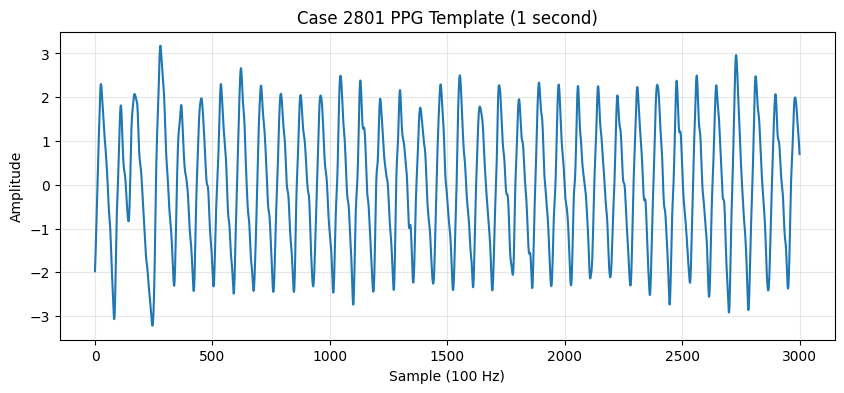

In [ ]:
# plt.figure(figsize=(10, 4))
# plt.plot(data[2000:5000])
# plt.title('Case 2801 PPG Template (1 second)')
# plt.xlabel('Sample (100 Hz)')
# plt.ylabel('Amplitude')
# plt.grid(True, alpha=0.3)
# plt.show()

In [ ]:
data = np.load('/content/drive/MyDrive/2025_PPG_GLUC/Data/Final Data/1s_segmentation2/case_6375_time_9683_1s_segments.npy')
print(data.shape)

(5, 100)


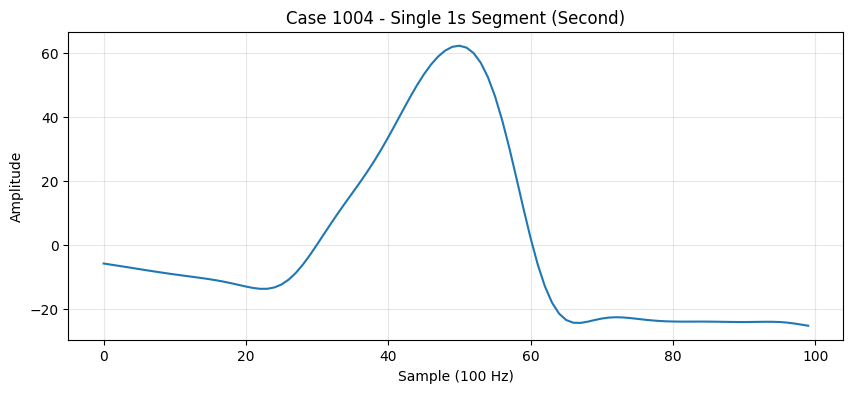

In [ ]:
# Or plot the second segment
plt.figure(figsize=(10, 4))
plt.plot(data[0])  # Second segment
plt.title('Case 1004 - Single 1s Segment (Second)')
plt.xlabel('Sample (100 Hz)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.show()


## Parameters

In [ ]:
# Signal parameters
FS = 100  # Sampling frequency (Hz)
WINDOW_SIZE = 100  # 1 second = 100 samples

# Thresholds from paper
HEIGHT_THRESHOLD = 20
DISTANCE_THRESHOLD = int(0.8 * FS)  # 0.8s min between peaks
SIMILARITY_THRESHOLD = 0.85

In [ ]:
# Get all filtered files
ppg_files = sorted(Path(INPUT_PATH).glob('case_*_filtered.npy'))
print(f"Found {len(ppg_files)} files to process\n")

Found 7300 files to process



## Calculating the template grouped by case. (INCORRECT)
* Each case may have multiple 16 min windows.

In [ ]:
# # Group files by caseid
# case_files = {}
# for ppg_file in ppg_files:
#     parts = ppg_file.stem.split('_')
#     caseid = int(parts[1])

#     if caseid not in case_files:
#         case_files[caseid] = []
#     case_files[caseid].append(ppg_file)

# print(f"Total unique cases: {len(case_files)}\n")

Total unique cases: 3091



In [ ]:
# # Quick diagnostic check
# from pathlib import Path
# import numpy as np

# INPUT_PATH = '/content/drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/'
# ppg_files = sorted(Path(INPUT_PATH).glob('case_*_filtered.npy'))

# print(f"Total files: {len(ppg_files)}\n")
# print("Checking file integrity...\n")

# corrupted = []
# empty = []
# too_small = []

# for ppg_file in ppg_files:
#     file_size = ppg_file.stat().st_size

#     # Check file size
#     if file_size == 0:
#         empty.append(ppg_file.name)
#         continue

#     if file_size < 1000:  # Very small files are suspicious
#         too_small.append((ppg_file.name, file_size))
#         continue

#     # Try loading
#     try:
#         data = np.load(ppg_file)
#         if len(data) != 96000:  # Should be exactly 96,000 samples
#             print(f"Wrong size: {ppg_file.name} has {len(data)} samples")
#     except Exception as e:
#         corrupted.append((ppg_file.name, str(e)))

# print(f"Empty files (0 bytes): {len(empty)}")
# print(f"Suspiciously small files: {len(too_small)}")
# print(f"Corrupted files: {len(corrupted)}")

# if empty:
#     print(f"\nFirst 5 empty files:")
#     for f in empty[:5]:
#         print(f"  {f}")

# if too_small:
#     print(f"\nSmall files:")
#     for f, size in too_small[:5]:
#         print(f"  {f} ({size} bytes)")

# if corrupted:
#     print(f"\nCorrupted files:")
#     f

Total files: 7302

Checking file integrity...

Empty files (0 bytes): 2
Suspiciously small files: 0
Corrupted files: 0

First 5 empty files:
  case_31_time_6721_filtered.npy
  case_46_time_4385_filtered.npy


In [ ]:
# empty_files = [
#     '/content/drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/case_31_time_6721_filtered.npy',
#     '/content/drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/case_46_time_4385_filtered.npy'
# ]

# for f in empty_files:
#     if os.path.exists(f):
#         os.remove(f)
#         print(f"Deleted: {f}")

Deleted: /content/drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/case_31_time_6721_filtered.npy
Deleted: /content/drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/case_46_time_4385_filtered.npy


In [ ]:
# templates = {}

# for caseid, files in tqdm(case_files.items(), desc="Creating templates"):
#     all_windows = []

#     # Collect all 1-second windows from all 16-min files for this case
#     for ppg_file in files:
#         try:
#             ppg_16min = np.load(ppg_file)
#         except (EOFError, ValueError, FileNotFoundError) as e:
#             # Skip corrupted/missing files
#             continue

#         n_windows = len(ppg_16min) // WINDOW_SIZE

#         for i in range(n_windows):
#             start = i * WINDOW_SIZE
#             end = start + WINDOW_SIZE
#             window = ppg_16min[start:end]

#             # Skip NaN windows
#             if not np.any(np.isnan(window)):
#                 all_windows.append(window)

#     # Create template as mean of all valid windows for this case
#     if len(all_windows) > 0:
#         templates[caseid] = np.mean(all_windows, axis=0)
#     else:
#         templates[caseid] = None

# print(f"\nTemplates created for {len([t for t in templates.values() if t is not None])} cases")
# print(f"Cases with no valid windows: {len([t for t in templates.values() if t is None])}\n")

# # Save templates
# TEMPLATE_PATH = '/content/drive/MyDrive/2025_PPG_GLUC/Data/Final Data/templates/'
# Path(TEMPLATE_PATH).mkdir(parents=True, exist_ok=True)

# for caseid, template in templates.items():
#     if template is not None:
#         np.save(f'{TEMPLATE_PATH}case_{caseid}_template.npy', template)

Creating templates: 100%|██████████| 3091/3091 [01:30<00:00, 34.05it/s]



Templates created for 3089 cases
Cases with no valid windows: 2



In [ ]:
# data = np.load('/content/drive/MyDrive/2025_PPG_GLUC/Data/Final Data/templates/case_5301_template.npy')
# print(data)

[-0.0294035  -0.02588041 -0.02052675 -0.01370512 -0.00582249  0.00267824
  0.01131544  0.01956605  0.02687192  0.03266481  0.03641408  0.03768752
  0.03620978  0.03190923  0.02494835  0.01573049  0.00487734 -0.00682417
 -0.0185028  -0.0293013  -0.03847012 -0.04543446 -0.04982376 -0.05146734
 -0.05037183 -0.04670016 -0.04076167 -0.03300919 -0.02403283 -0.01453635
 -0.00528366  0.00298372  0.00963926  0.01424646  0.01659399  0.01668244
  0.01467255  0.01082097  0.00543037 -0.00117254 -0.00863331 -0.01655416
 -0.02448433 -0.03192962 -0.03838389 -0.04337439 -0.04650913 -0.04751878
 -0.04628933 -0.04287997 -0.03751889 -0.03057368 -0.02250062 -0.01378384
 -0.00487946  0.00381816  0.01198058  0.01932951  0.02561685  0.03061077
  0.03409752  0.03590732  0.0359555   0.03427415  0.03101755  0.02644714
  0.02090909  0.01480746  0.00857025  0.0026126  -0.00269144 -0.00702065
 -0.01010412 -0.01171605 -0.0116807  -0.0098912  -0.00633517 -0.00111878
  0.00551708  0.01319689  0.02143523  0.02968509  0

## TO CHANGE
* Follow in this order> peak detection > extract 1s window around each peak > create template > do cosine similarity

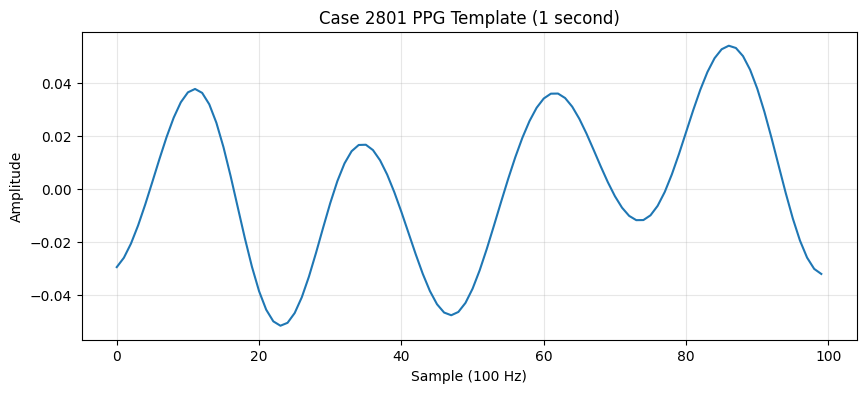

In [ ]:
# plt.figure(figsize=(10, 4))
# plt.plot(data)
# plt.title('Case 2801 PPG Template (1 second)')
# plt.xlabel('Sample (100 Hz)')
# plt.ylabel('Amplitude')
# plt.grid(True, alpha=0.3)
# plt.show()

## Correct Processing order
* Peak detection on 16 min window to find all systolic peaks
* Extract 1s windows on each peak
* Create the template (mean of all windows per case)
* Perform Cosine similarity filtering (threshold at 0.85)
* Height threshold at 20 amplitude
* Distance threshold set to 0.8s min between peaks

## Peak Detection
- Using scipy's find_peaks, prominence set to 0

In [ ]:
def detect_peaks(ppg_signal, height_threshold=HEIGHT_THRESHOLD,
                 distance_threshold=DISTANCE_THRESHOLD, sampling_rate=FS):
    peaks, _ = find_peaks(
        ppg_signal,
        height=height_threshold,
        distance=distance_threshold
    )

    return peaks

## Extract Windows
- Extracts 1s windows centered on each peak
- Only keep windows that contain exactly 1 peak
- window_size set to 100 samples (1s)
- Returns: list of valid windows (windows)

In [ ]:
def extract_windows(ppg_signal, peaks, window_size):
    windows = []
    half_window = window_size // 2  # 50 samples

    for peak in peaks:
        # Calculate window boundaries
        window_start = max(0, peak - half_window)
        window_end = min(len(ppg_signal), peak + half_window)

        # Extract window
        window = ppg_signal[window_start:window_end]

        # Skip if window is not full size or contains NaN
        if len(window) != window_size or np.any(np.isnan(window)):
            continue

        # Count peaks in this window
        peak_count = count_peaks_in_window(window, height_threshold=HEIGHT_THRESHOLD)

        # Only keep if exactly 1 peak
        if peak_count == 1:
            windows.append(window)

    return windows

## Count Peaks in Window

In [ ]:
def count_peaks_in_window(window, height_threshold):

    count = 0

    for i in range(1, len(window) - 1):
        if window[i-1] < window[i] > window[i+1]:
            if window[i] > height_threshold:
                count += 1

    return count

## Computing Template
- Computes template in each 16 minute window
- As there may be temporal changes within a case
- i.e blood pressure changes / patient movement / medication given
- According to the pseudocode by the paper, they calculate template using mean of 16 min window

In [ ]:
def compute_template(windows):

    if len(windows) == 0:
        return None

    template = np.mean(windows, axis=0)
    return template

## Cosine Similarity
- Computes Cosine Similarity between window and template
- Returns: Cosine Similarity score [0,1]

In [ ]:
def cosine_similarity(window, template):

    if template is None or len(window) != len(template):
        return 0.0

    # Using scipy's cosine distance: similarity = 1 - distance
    similarity = 1 - cosine(window, template)

    return similarity

## Filter windows by similarity
- Filters windows by cosine similairity to template
- Returns: List of windows passing threshold

In [ ]:
def filter_windows_by_similarity(windows, template, similarity_threshold):

    filtered_windows = []

    for window in windows:
        similarity = cosine_similarity(window, template)

        if similarity >= similarity_threshold:
            filtered_windows.append(window)

    return filtered_windows


In [ ]:
def main_process_window(ppg_signal):

    # Step 1: Detect peaks
    peaks = detect_peaks(ppg_signal, HEIGHT_THRESHOLD, DISTANCE_THRESHOLD)

    # Step 2: Extract windows centered on peaks
    windows = extract_windows(ppg_signal, peaks, WINDOW_SIZE)

    # Step 3: Compute template
    template = compute_template(windows)

    # Step 4: Filter by similarity
    if template is not None:
        filtered_windows = filter_windows_by_similarity(windows, template, SIMILARITY_THRESHOLD)
    else:
        filtered_windows = []

    # Statistics
    stats = {
        'n_peaks': len(peaks),
        'n_windows_extracted': len(windows),
        'n_windows_filtered': len(filtered_windows),
        'rejection_rate': 1 - (len(filtered_windows) / len(peaks)) if len(peaks) > 0 else 1.0
    }

    return filtered_windows, stats


In [ ]:
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

ppg_files = sorted(Path(INPUT_PATH).glob('case_*_filtered.npy'))
print(f"Found {len(ppg_files)} files to process\n")

results = []

for ppg_file in tqdm(ppg_files, desc="Processing files"):
    # Parse filename
    parts = ppg_file.stem.split('_')
    caseid = int(parts[1])
    glucose_time = int(parts[3])

    # Load 16-minute PPG window
    try:
        ppg_16min = np.load(ppg_file)
    except (EOFError, ValueError, FileNotFoundError):
        results.append({
            'caseid': caseid,
            'glucose_time': glucose_time,
            'n_peaks': 0,
            'n_windows_extracted': 0,
            'n_windows_filtered': 0,
            'rejection_rate': 1.0
        })
        continue

    # Process this 16-min window
    filtered_windows, stats = main_process_window(ppg_16min)

    # Save valid segments if any
    if len(filtered_windows) > 0:
        segments_array = np.array(filtered_windows)  # Shape: (n_segments, 100)
        output_file = Path(OUTPUT_PATH) / f'case_{caseid}_time_{glucose_time}_1s_segments.npy'
        np.save(output_file, segments_array)

    # Track results
    results.append({
        'caseid': caseid,
        'glucose_time': glucose_time,
        'n_peaks': stats['n_peaks'],
        'n_windows_extracted': stats['n_windows_extracted'],
        'n_windows_filtered': stats['n_windows_filtered'],
        'rejection_rate': stats['rejection_rate']
    })

Found 7300 files to process



Processing files: 100%|██████████| 7300/7300 [16:57<00:00,  7.17it/s]


In [ ]:
summary_df = pd.DataFrame(results)
summary_df.to_csv(Path(OUTPUT_PATH).parent / '1s_seg_metadata.csv', index=False)

In [ ]:
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
successful = summary_df[summary_df['n_windows_filtered'] > 0]
print(f"Total files processed: {len(summary_df)}")
print(f"Files with valid segments: {len(successful)} ({len(successful)/len(summary_df)*100:.1f}%)")
print(f"\nMean peaks detected: {summary_df['n_peaks'].mean():.1f}")
print(f"Mean windows extracted: {summary_df['n_windows_extracted'].mean():.1f}")
print(f"Mean final segments: {successful['n_windows_filtered'].mean():.1f}")
print(f"Total segments generated: {successful['n_windows_filtered'].sum()}")
print(f"Mean rejection rate: {successful['rejection_rate'].mean()*100:.1f}%")
print("="*60)


SUMMARY
Total files processed: 7300
Files with valid segments: 5969 (81.8%)

Mean peaks detected: 417.9
Mean windows extracted: 412.6
Mean final segments: 496.6
Total segments generated: 2963923
Mean rejection rate: 9.7%


## Visualization of find_peaks

Total files available: 7300

Testing on these files:
  1. case_1001_time_2625_filtered.npy
  2. case_1001_time_7432_filtered.npy
  3. case_1002_time_3269_filtered.npy


Case 1001, Glucose Time 2625
Signal length: 96000 samples (16.0 minutes)
Signal range: [-17.27, 44.39]

Peak Detection Results:
  Total peaks detected: 792
  Expected peaks (at ~75 BPM): 1200 peaks
  Average peak height: 25.84
  Peak indices (first 10): [37, 134, 229, 325, 423, 545, 766, 866, 962, 1056]

REJECTION ANALYSIS

1. Total local maxima found: 1527

2. Height Filter (must be > 20):
   Passed: 897
   Rejected: 630 (41.3%)

3. Distance Filter (must be > 80 samples = 0.8s apart):
   Passed: 797
   Rejected: 100 (11.1%)

REJECTION SUMMARY
  Started with: 1527 local maxima
  → Height rejected: 630 (too low)
  → Distance rejected: 100 (too close to previous peak)
  → Final peaks: 792
  → Overall rejection rate: 48.1%

Heart Rate Statistics:
  Mean HR: 54.0 BPM
  Min HR: 15.7 BPM
  Max HR: 75.0 BPM
  Std HR: 13.5 BPM


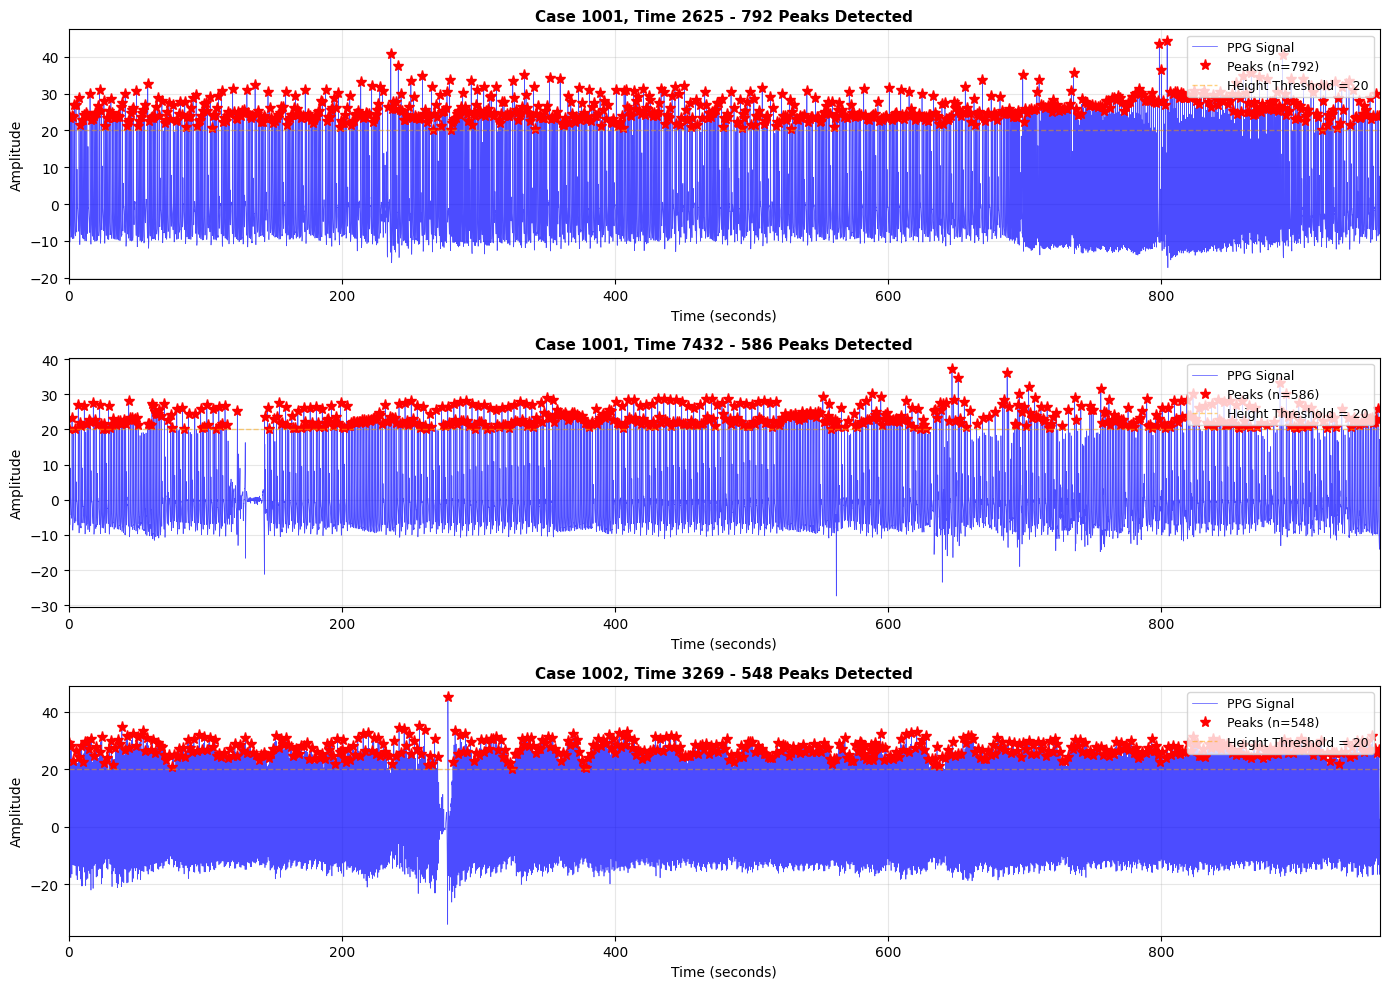


SUMMARY

Parameters used:
  Height threshold: 20
  Distance threshold: 80 samples (0.8 seconds)
  Prominence threshold: 10

Plot saved to: /content/peak_detection_test.png

DETAILED VIEW: 10-second window


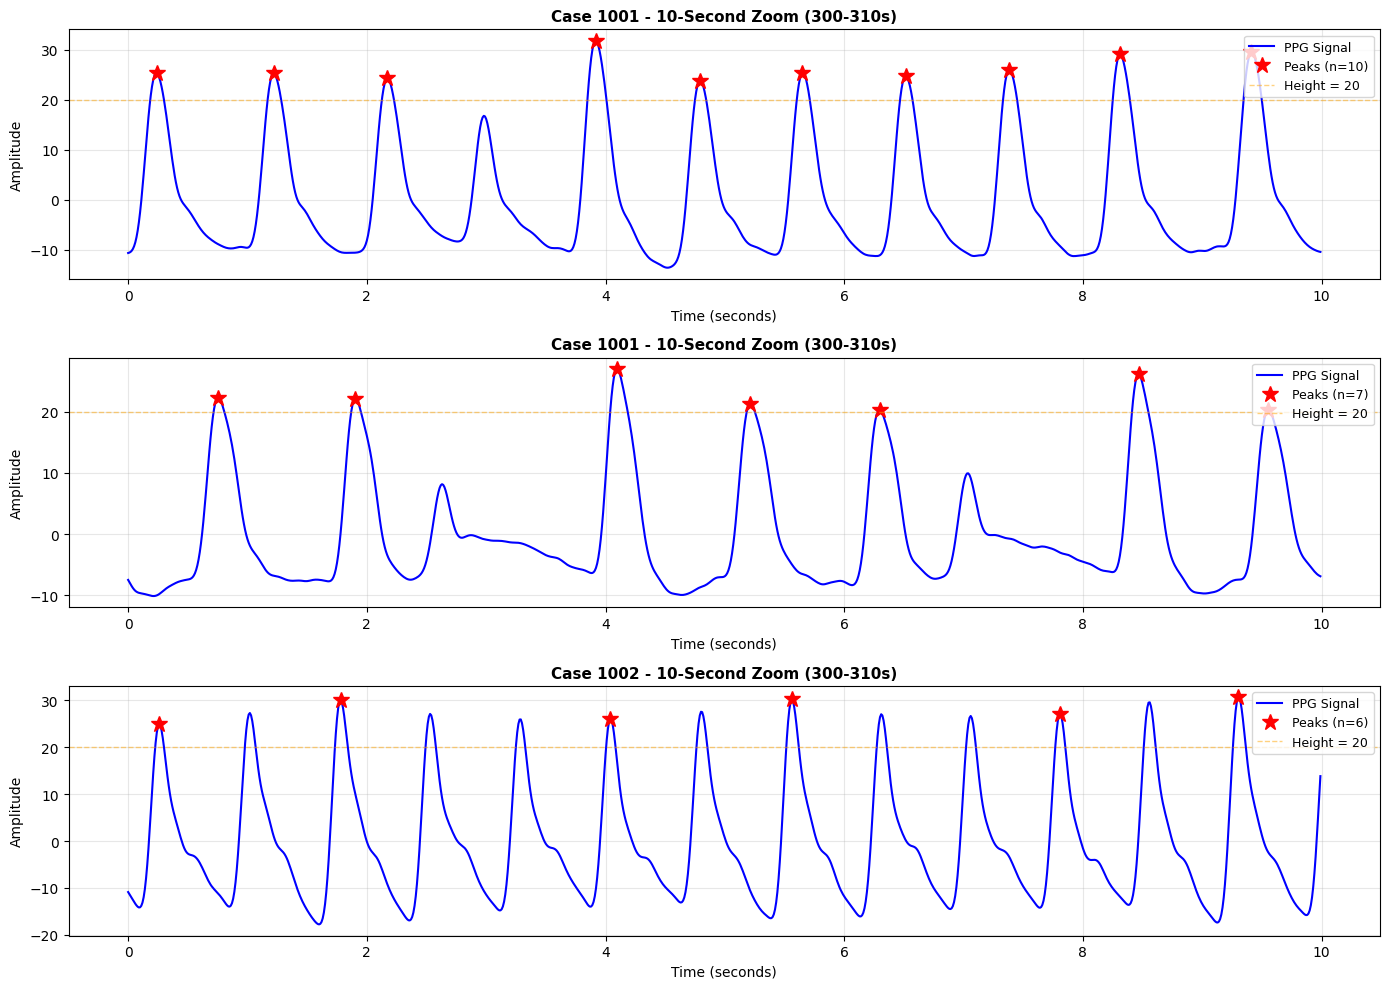


Zoomed plot saved to: /content/peak_detection_zoom.png


In [ ]:
"""
Test scipy's find_peaks on sample PPG signals
Visualize detected peaks on 2-3 cases
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from pathlib import Path

# ============================================================================
# PARAMETERS
# ============================================================================

INPUT_PATH = '/content/drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/'

# Peak detection parameters
FS = 100  # Sampling rate (Hz)
HEIGHT_THRESHOLD = 20
DISTANCE_THRESHOLD = int(0.8 * FS)  # 80 samples = 0.8 seconds
PROMINENCE_THRESHOLD = 10  # Set to 0 as requested

# ============================================================================
# LOAD SAMPLE FILES
# ============================================================================

# Get all filtered files
ppg_files = sorted(Path(INPUT_PATH).glob('case_*_filtered.npy'))
print(f"Total files available: {len(ppg_files)}\n")

# Select 3 sample files
sample_files = ppg_files[:3]

print("Testing on these files:")
for i, file in enumerate(sample_files, 1):
    print(f"  {i}. {file.name}")
print()

# ============================================================================
# TEST PEAK DETECTION
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for idx, ppg_file in enumerate(sample_files):
    # Parse filename
    parts = ppg_file.stem.split('_')
    caseid = parts[1]
    glucose_time = parts[3]

    # Load 16-minute PPG window
    ppg_signal = np.load(ppg_file)

    print(f"\n{'='*60}")
    print(f"Case {caseid}, Glucose Time {glucose_time}")
    print(f"{'='*60}")
    print(f"Signal length: {len(ppg_signal)} samples ({len(ppg_signal)/FS/60:.1f} minutes)")
    print(f"Signal range: [{ppg_signal.min():.2f}, {ppg_signal.max():.2f}]")

    # Detect peaks using scipy's find_peaks
    peaks, properties = find_peaks(
        ppg_signal,
        height=HEIGHT_THRESHOLD,
        distance=DISTANCE_THRESHOLD,
        prominence=PROMINENCE_THRESHOLD if PROMINENCE_THRESHOLD > 0 else None
    )

    print(f"\nPeak Detection Results:")
    print(f"  Total peaks detected: {len(peaks)}")
    print(f"  Expected peaks (at ~75 BPM): {int(16 * 75)} peaks")
    print(f"  Average peak height: {ppg_signal[peaks].mean():.2f}")
    print(f"  Peak indices (first 10): {peaks[:10].tolist()}")

    # ========================================================================
    # ANALYZE REJECTION REASONS
    # ========================================================================

    print(f"\n{'='*50}")
    print("REJECTION ANALYSIS")
    print(f"{'='*50}")

    # Find ALL local maxima (without any filters)
    all_local_max = []
    for i in range(1, len(ppg_signal) - 1):
        if ppg_signal[i-1] < ppg_signal[i] > ppg_signal[i+1]:
            all_local_max.append(i)

    print(f"\n1. Total local maxima found: {len(all_local_max)}")

    # Check height filter
    height_pass = [i for i in all_local_max if ppg_signal[i] > HEIGHT_THRESHOLD]
    height_rejected = len(all_local_max) - len(height_pass)
    print(f"\n2. Height Filter (must be > {HEIGHT_THRESHOLD}):")
    print(f"   Passed: {len(height_pass)}")
    print(f"   Rejected: {height_rejected} ({height_rejected/len(all_local_max)*100:.1f}%)")

    # Check distance filter
    distance_pass = []
    for i in height_pass:
        # Check if this peak is at least DISTANCE_THRESHOLD away from all previously accepted peaks
        if len(distance_pass) == 0 or all((i - prev) > DISTANCE_THRESHOLD for prev in distance_pass):
            distance_pass.append(i)

    distance_rejected = len(height_pass) - len(distance_pass)
    print(f"\n3. Distance Filter (must be > {DISTANCE_THRESHOLD} samples = {DISTANCE_THRESHOLD/FS}s apart):")
    print(f"   Passed: {len(distance_pass)}")
    print(f"   Rejected: {distance_rejected} ({distance_rejected/len(height_pass)*100:.1f}%)")

    # Summary
    print(f"\n{'='*50}")
    print("REJECTION SUMMARY")
    print(f"{'='*50}")
    print(f"  Started with: {len(all_local_max)} local maxima")
    print(f"  → Height rejected: {height_rejected} (too low)")
    print(f"  → Distance rejected: {distance_rejected} (too close to previous peak)")
    print(f"  → Final peaks: {len(peaks)}")
    print(f"  → Overall rejection rate: {(1 - len(peaks)/len(all_local_max))*100:.1f}%")

    # Calculate inter-peak intervals
    if len(peaks) > 1:
        intervals = np.diff(peaks) / FS  # Convert to seconds
        heart_rate = 60 / intervals  # BPM
        print(f"\nHeart Rate Statistics:")
        print(f"  Mean HR: {heart_rate.mean():.1f} BPM")
        print(f"  Min HR: {heart_rate.min():.1f} BPM")
        print(f"  Max HR: {heart_rate.max():.1f} BPM")
        print(f"  Std HR: {heart_rate.std():.1f} BPM")

    # ========================================================================
    # PLOT: Full 16-minute signal with peaks
    # ========================================================================

    ax = axes[idx]

    # Time axis (in seconds)
    time = np.arange(len(ppg_signal)) / FS

    # Plot signal
    ax.plot(time, ppg_signal, 'b-', linewidth=0.5, label='PPG Signal', alpha=0.7)

    # Plot detected peaks
    ax.plot(time[peaks], ppg_signal[peaks], 'r*', markersize=8, label=f'Peaks (n={len(peaks)})')

    # Add horizontal line at height threshold
    ax.axhline(y=HEIGHT_THRESHOLD, color='orange', linestyle='--',
               linewidth=1, alpha=0.5, label=f'Height Threshold = {HEIGHT_THRESHOLD}')

    # Labels and title
    ax.set_xlabel('Time (seconds)', fontsize=10)
    ax.set_ylabel('Amplitude', fontsize=10)
    ax.set_title(f'Case {caseid}, Time {glucose_time} - {len(peaks)} Peaks Detected',
                 fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

    # Set x-axis to show full signal
    ax.set_xlim([0, len(ppg_signal)/FS])

plt.tight_layout()
plt.savefig('/content/peak_detection_test.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("SUMMARY")
print(f"{'='*60}")
print(f"\nParameters used:")
print(f"  Height threshold: {HEIGHT_THRESHOLD}")
print(f"  Distance threshold: {DISTANCE_THRESHOLD} samples ({DISTANCE_THRESHOLD/FS} seconds)")
print(f"  Prominence threshold: {PROMINENCE_THRESHOLD}")
print(f"\nPlot saved to: /content/peak_detection_test.png")

# ============================================================================
# ZOOM IN: Show 10-second window for detailed view
# ============================================================================

print(f"\n{'='*60}")
print("DETAILED VIEW: 10-second window")
print(f"{'='*60}")

fig2, axes2 = plt.subplots(3, 1, figsize=(14, 10))

for idx, ppg_file in enumerate(sample_files):
    # Parse filename
    parts = ppg_file.stem.split('_')
    caseid = parts[1]
    glucose_time = parts[3]

    # Load signal
    ppg_signal = np.load(ppg_file)

    # Detect peaks
    peaks, _ = find_peaks(
        ppg_signal,
        height=HEIGHT_THRESHOLD,
        distance=DISTANCE_THRESHOLD,
        prominence=PROMINENCE_THRESHOLD if PROMINENCE_THRESHOLD > 0 else None
    )

    # Extract 10-second window (samples 30000:31000 = 300-310 seconds)
    start_sample = 30000
    end_sample = start_sample + 1000  # 10 seconds at 100 Hz

    window_signal = ppg_signal[start_sample:end_sample]
    window_peaks = peaks[(peaks >= start_sample) & (peaks < end_sample)] - start_sample

    ax = axes2[idx]

    # Time axis for window
    time_window = np.arange(len(window_signal)) / FS

    # Plot signal
    ax.plot(time_window, window_signal, 'b-', linewidth=1.5, label='PPG Signal')

    # Plot peaks
    ax.plot(time_window[window_peaks], window_signal[window_peaks],
            'r*', markersize=12, label=f'Peaks (n={len(window_peaks)})')

    # Add threshold line
    ax.axhline(y=HEIGHT_THRESHOLD, color='orange', linestyle='--',
               linewidth=1, alpha=0.5, label=f'Height = {HEIGHT_THRESHOLD}')

    # Labels
    ax.set_xlabel('Time (seconds)', fontsize=10)
    ax.set_ylabel('Amplitude', fontsize=10)
    ax.set_title(f'Case {caseid} - 10-Second Zoom (300-310s)',
                 fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/peak_detection_zoom.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nZoomed plot saved to: /content/peak_detection_zoom.png")

In [ ]:
!pip install vitaldb neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 135.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 w

Total files available: 7300

Testing on these files:
  1. case_1001_time_2625_filtered.npy
  2. case_1001_time_7432_filtered.npy
  3. case_1002_time_3269_filtered.npy


Case 1001, Glucose Time 2625
Signal length: 96000 samples (16.0 minutes)
Signal range: [-17.27, 44.39]

──────────────────────────────────────────────────────────────────────
METHOD 1: YOUR CUSTOM ALGORITHM
──────────────────────────────────────────────────────────────────────
Total peaks detected: 797
Expected peaks (at ~75 BPM): 1200 peaks
Average peak height: 25.75
Mean HR: 54.0 BPM (std: 13.2)

Rejection Analysis:
  Local maxima: 1527
  Height rejected: 630 (41.3%)
  Distance rejected: 100 (11.1%)
  Final peaks: 797
  Overall rejection: 47.8%

──────────────────────────────────────────────────────────────────────
METHOD 2: SCIPY find_peaks
──────────────────────────────────────────────────────────────────────
Total peaks detected: 792
Expected peaks (at ~75 BPM): 1200 peaks
Average peak height: 25.84
Mean HR: 54.0 B

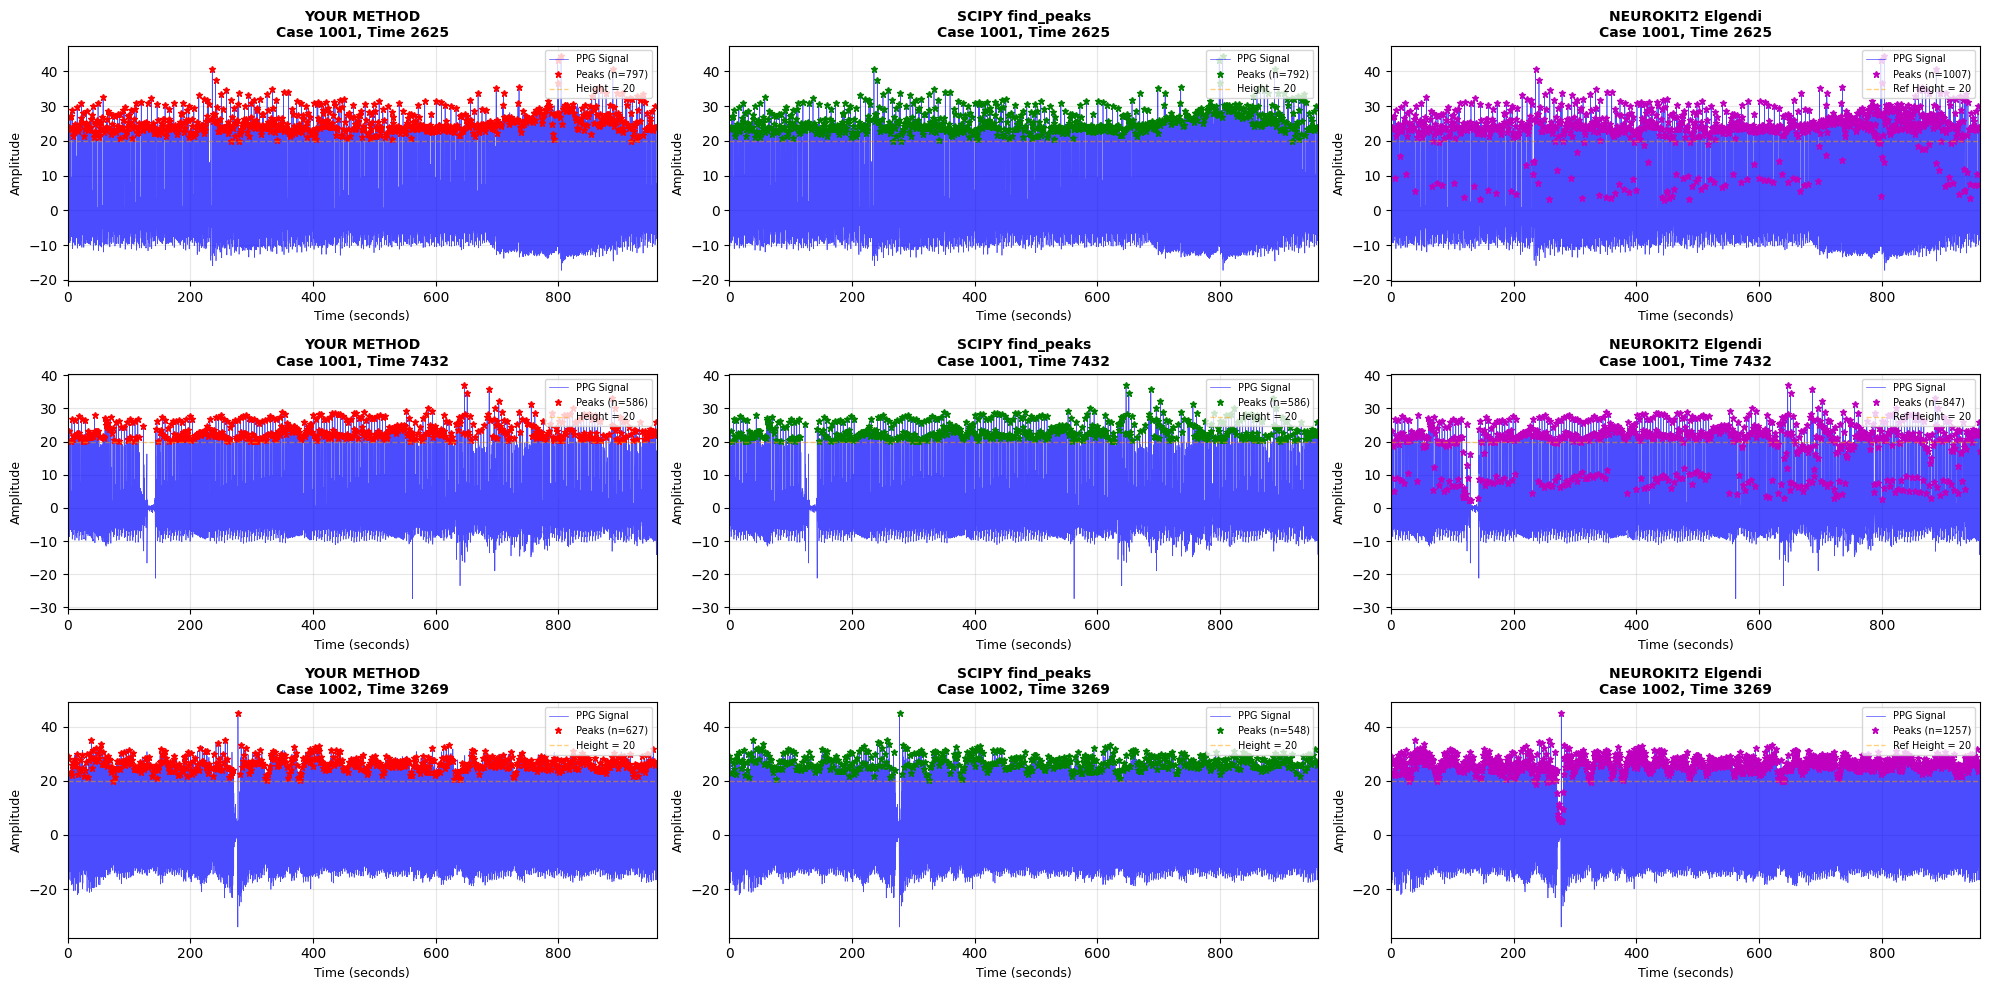


OVERALL SUMMARY

Creating zoomed comparison (10-second windows)...


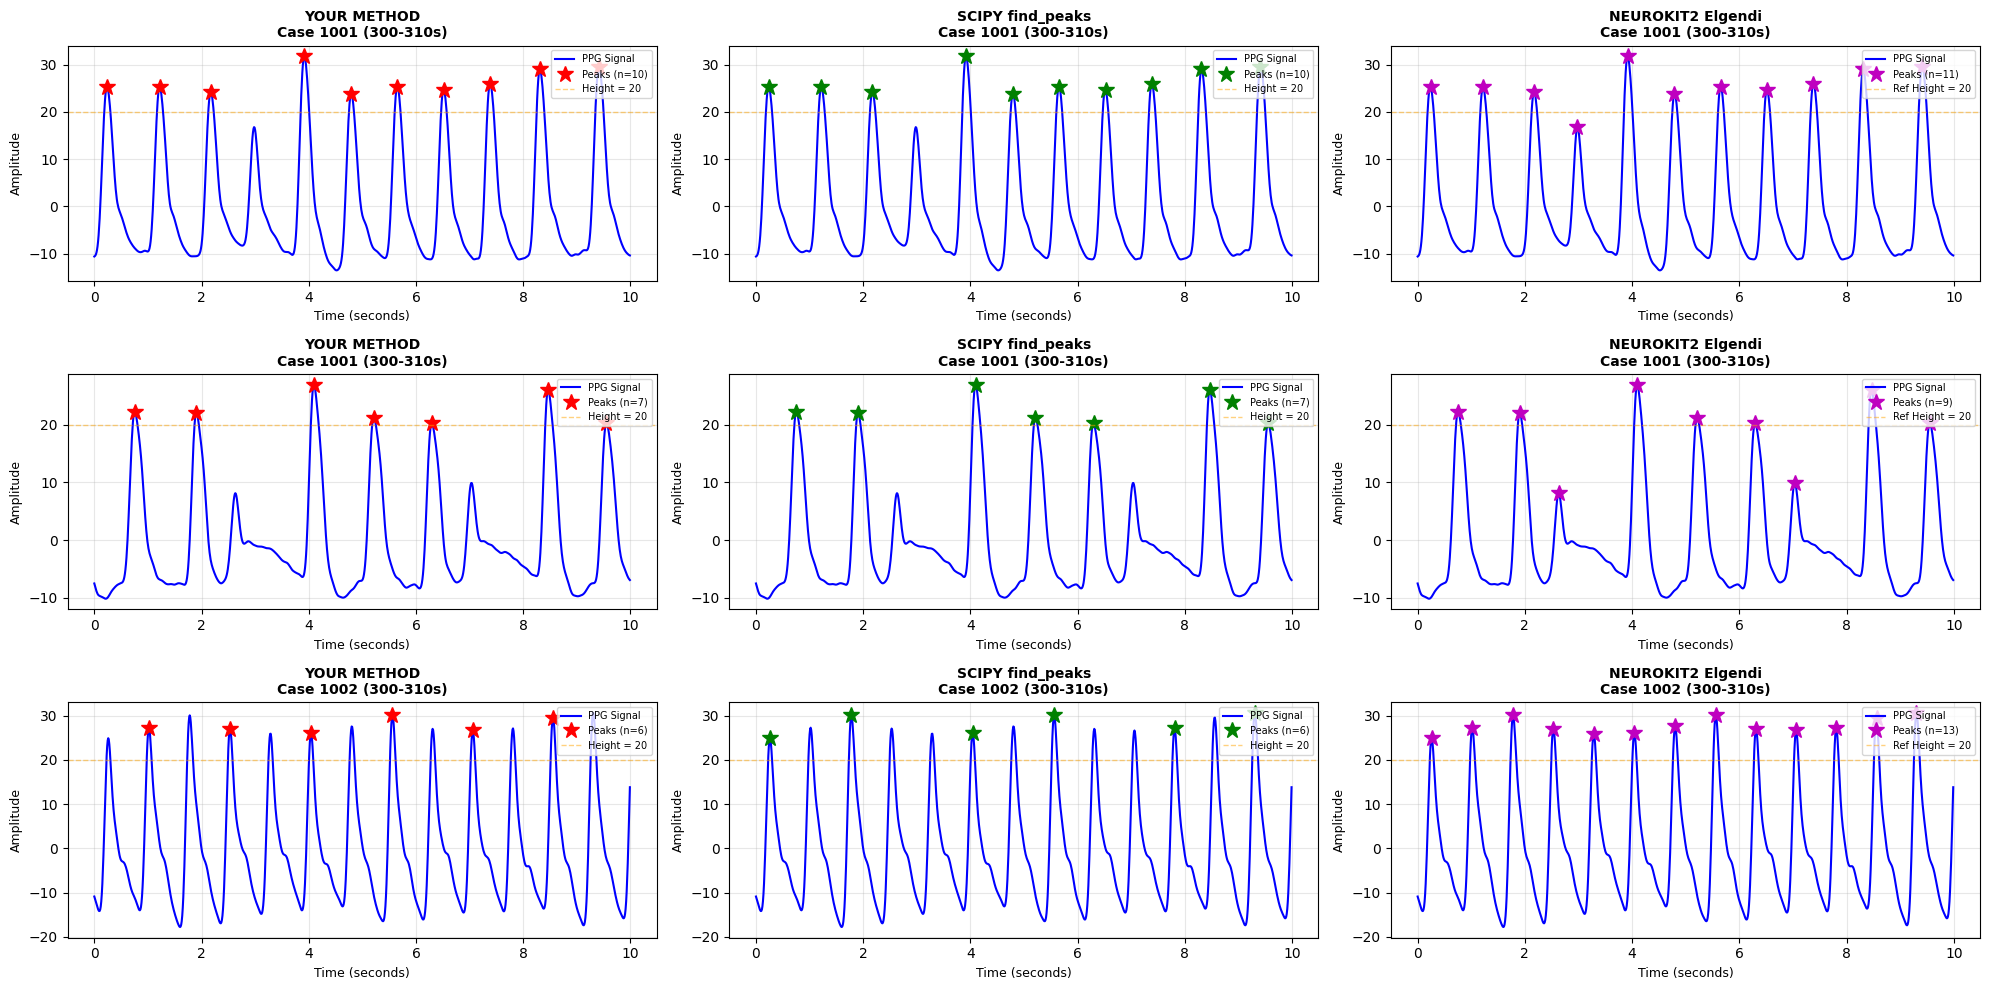


Plots saved:
  - /content/comparison_three_methods_full.png (full 16-minute signals)
  - /content/comparison_three_methods_zoom.png (10-second zoom)


In [ ]:
"""
Test all three peak detection methods on same 3 sample cases
1. Your custom method
2. Scipy find_peaks
3. NeuroKit2 ppg_findpeaks
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import neurokit2 as nk
from pathlib import Path

# ============================================================================
# PARAMETERS
# ============================================================================

INPUT_PATH = '/content/drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/'

# Peak detection parameters
FS = 100  # Sampling rate (Hz)
HEIGHT_THRESHOLD = 20
DISTANCE_THRESHOLD = int(0.8 * FS)  # 80 samples = 0.8 seconds

# ============================================================================
# YOUR CUSTOM PEAK DETECTION METHOD
# ============================================================================

def detect_peaks_custom(ppg_signal, height_threshold, distance_threshold):
    """
    Your original peak detection algorithm
    """
    peaks = []

    for i in range(1, len(ppg_signal) - 1):
        # Check if local maximum
        if ppg_signal[i-1] < ppg_signal[i] > ppg_signal[i+1]:
            # Check height threshold
            if ppg_signal[i] > height_threshold:
                # Check distance from last peak
                if len(peaks) == 0 or (i - peaks[-1]) > distance_threshold:
                    peaks.append(i)

    return peaks

# ============================================================================
# LOAD SAMPLE FILES
# ============================================================================

# Get all filtered files
ppg_files = sorted(Path(INPUT_PATH).glob('case_*_filtered.npy'))
print(f"Total files available: {len(ppg_files)}\n")

# Select same 3 sample files
sample_files = ppg_files[:3]

print("Testing on these files:")
for i, file in enumerate(sample_files, 1):
    print(f"  {i}. {file.name}")
print()

# ============================================================================
# TEST ALL THREE METHODS
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for idx, ppg_file in enumerate(sample_files):
    # Parse filename
    parts = ppg_file.stem.split('_')
    caseid = parts[1]
    glucose_time = parts[3]

    # Load 16-minute PPG window
    ppg_signal = np.load(ppg_file)

    print(f"\n{'='*70}")
    print(f"Case {caseid}, Glucose Time {glucose_time}")
    print(f"{'='*70}")
    print(f"Signal length: {len(ppg_signal)} samples ({len(ppg_signal)/FS/60:.1f} minutes)")
    print(f"Signal range: [{ppg_signal.min():.2f}, {ppg_signal.max():.2f}]")

    # ========================================================================
    # METHOD 1: YOUR CUSTOM METHOD
    # ========================================================================

    print(f"\n{'─'*70}")
    print("METHOD 1: YOUR CUSTOM ALGORITHM")
    print(f"{'─'*70}")

    peaks_custom = detect_peaks_custom(ppg_signal, HEIGHT_THRESHOLD, DISTANCE_THRESHOLD)

    print(f"Total peaks detected: {len(peaks_custom)}")
    print(f"Expected peaks (at ~75 BPM): {int(16 * 75)} peaks")
    if len(peaks_custom) > 0:
        print(f"Average peak height: {ppg_signal[peaks_custom].mean():.2f}")

    # Calculate heart rate
    if len(peaks_custom) > 1:
        intervals = np.diff(peaks_custom) / FS
        heart_rate = 60 / intervals
        print(f"Mean HR: {heart_rate.mean():.1f} BPM (std: {heart_rate.std():.1f})")

    # Rejection analysis
    all_local_max = []
    for i in range(1, len(ppg_signal) - 1):
        if ppg_signal[i-1] < ppg_signal[i] > ppg_signal[i+1]:
            all_local_max.append(i)

    height_pass = [i for i in all_local_max if ppg_signal[i] > HEIGHT_THRESHOLD]
    height_rejected = len(all_local_max) - len(height_pass)
    distance_rejected = len(height_pass) - len(peaks_custom)

    print(f"\nRejection Analysis:")
    print(f"  Local maxima: {len(all_local_max)}")
    print(f"  Height rejected: {height_rejected} ({height_rejected/len(all_local_max)*100:.1f}%)")
    print(f"  Distance rejected: {distance_rejected} ({distance_rejected/len(height_pass)*100:.1f}%)")
    print(f"  Final peaks: {len(peaks_custom)}")
    print(f"  Overall rejection: {(1 - len(peaks_custom)/len(all_local_max))*100:.1f}%")

    # ========================================================================
    # METHOD 2: SCIPY find_peaks
    # ========================================================================

    print(f"\n{'─'*70}")
    print("METHOD 2: SCIPY find_peaks")
    print(f"{'─'*70}")

    peaks_scipy, _ = find_peaks(
        ppg_signal,
        height=HEIGHT_THRESHOLD,
        distance=DISTANCE_THRESHOLD
    )

    print(f"Total peaks detected: {len(peaks_scipy)}")
    print(f"Expected peaks (at ~75 BPM): {int(16 * 75)} peaks")
    if len(peaks_scipy) > 0:
        print(f"Average peak height: {ppg_signal[peaks_scipy].mean():.2f}")

    # Calculate heart rate
    if len(peaks_scipy) > 1:
        intervals = np.diff(peaks_scipy) / FS
        heart_rate = 60 / intervals
        print(f"Mean HR: {heart_rate.mean():.1f} BPM (std: {heart_rate.std():.1f})")

    # ========================================================================
    # METHOD 3: NEUROKIT2 ppg_findpeaks
    # ========================================================================

    print(f"\n{'─'*70}")
    print("METHOD 3: NEUROKIT2 ppg_findpeaks (Elgendi)")
    print(f"{'─'*70}")

    try:
        info_nk = nk.ppg_findpeaks(ppg_signal, sampling_rate=FS, method="elgendi")
        peaks_nk = info_nk['PPG_Peaks']

        print(f"Total peaks detected: {len(peaks_nk)}")
        print(f"Expected peaks (at ~75 BPM): {int(16 * 75)} peaks")
        if len(peaks_nk) > 0:
            print(f"Average peak height: {ppg_signal[peaks_nk].mean():.2f}")

        # Calculate heart rate
        if len(peaks_nk) > 1:
            intervals = np.diff(peaks_nk) / FS
            heart_rate = 60 / intervals
            print(f"Mean HR: {heart_rate.mean():.1f} BPM (std: {heart_rate.std():.1f})")
    except Exception as e:
        print(f"ERROR: {e}")
        peaks_nk = []

    # ========================================================================
    # COMPARISON
    # ========================================================================

    print(f"\n{'─'*70}")
    print("THREE-WAY COMPARISON")
    print(f"{'─'*70}")

    # Find peaks detected by each method
    peaks_custom_set = set(peaks_custom)
    peaks_scipy_set = set(peaks_scipy)
    peaks_nk_set = set(peaks_nk)

    all_three = peaks_custom_set & peaks_scipy_set & peaks_nk_set
    custom_scipy_only = (peaks_custom_set & peaks_scipy_set) - peaks_nk_set
    custom_nk_only = (peaks_custom_set & peaks_nk_set) - peaks_scipy_set
    scipy_nk_only = (peaks_scipy_set & peaks_nk_set) - peaks_custom_set
    only_custom = peaks_custom_set - peaks_scipy_set - peaks_nk_set
    only_scipy = peaks_scipy_set - peaks_custom_set - peaks_nk_set
    only_nk = peaks_nk_set - peaks_custom_set - peaks_scipy_set

    print(f"Detected by all three: {len(all_three)}")
    print(f"Detected by Custom + Scipy (not NK): {len(custom_scipy_only)}")
    print(f"Detected by Custom + NK (not Scipy): {len(custom_nk_only)}")
    print(f"Detected by Scipy + NK (not Custom): {len(scipy_nk_only)}")
    print(f"Only by Custom: {len(only_custom)}")
    print(f"Only by Scipy: {len(only_scipy)}")
    print(f"Only by NeuroKit2: {len(only_nk)}")

    print(f"\nPairwise Agreement:")
    if len(peaks_custom) > 0 and len(peaks_scipy) > 0:
        print(f"  Custom vs Scipy: {len(peaks_custom_set & peaks_scipy_set) / max(len(peaks_custom), len(peaks_scipy)) * 100:.1f}%")
    if len(peaks_custom) > 0 and len(peaks_nk) > 0:
        print(f"  Custom vs NK: {len(peaks_custom_set & peaks_nk_set) / max(len(peaks_custom), len(peaks_nk)) * 100:.1f}%")
    if len(peaks_scipy) > 0 and len(peaks_nk) > 0:
        print(f"  Scipy vs NK: {len(peaks_scipy_set & peaks_nk_set) / max(len(peaks_scipy), len(peaks_nk)) * 100:.1f}%")

    # ========================================================================
    # PLOT: CUSTOM METHOD
    # ========================================================================

    ax1 = axes[idx, 0]
    time = np.arange(len(ppg_signal)) / FS

    ax1.plot(time, ppg_signal, 'b-', linewidth=0.5, alpha=0.7, label='PPG Signal')
    ax1.plot(time[peaks_custom], ppg_signal[peaks_custom],
             'r*', markersize=5, label=f'Peaks (n={len(peaks_custom)})')
    ax1.axhline(y=HEIGHT_THRESHOLD, color='orange', linestyle='--',
                linewidth=1, alpha=0.5, label=f'Height = {HEIGHT_THRESHOLD}')

    ax1.set_xlabel('Time (seconds)', fontsize=9)
    ax1.set_ylabel('Amplitude', fontsize=9)
    ax1.set_title(f'YOUR METHOD\nCase {caseid}, Time {glucose_time}',
                  fontsize=10, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=7)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, len(ppg_signal)/FS])

    # ========================================================================
    # PLOT: SCIPY METHOD
    # ========================================================================

    ax2 = axes[idx, 1]

    ax2.plot(time, ppg_signal, 'b-', linewidth=0.5, alpha=0.7, label='PPG Signal')
    ax2.plot(time[peaks_scipy], ppg_signal[peaks_scipy],
             'g*', markersize=5, label=f'Peaks (n={len(peaks_scipy)})')
    ax2.axhline(y=HEIGHT_THRESHOLD, color='orange', linestyle='--',
                linewidth=1, alpha=0.5, label=f'Height = {HEIGHT_THRESHOLD}')

    ax2.set_xlabel('Time (seconds)', fontsize=9)
    ax2.set_ylabel('Amplitude', fontsize=9)
    ax2.set_title(f'SCIPY find_peaks\nCase {caseid}, Time {glucose_time}',
                  fontsize=10, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=7)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, len(ppg_signal)/FS])

    # ========================================================================
    # PLOT: NEUROKIT2 METHOD
    # ========================================================================

    ax3 = axes[idx, 2]

    ax3.plot(time, ppg_signal, 'b-', linewidth=0.5, alpha=0.7, label='PPG Signal')
    if len(peaks_nk) > 0:
        ax3.plot(time[peaks_nk], ppg_signal[peaks_nk],
                 'm*', markersize=5, label=f'Peaks (n={len(peaks_nk)})')
    ax3.axhline(y=HEIGHT_THRESHOLD, color='orange', linestyle='--',
                linewidth=1, alpha=0.5, label=f'Ref Height = {HEIGHT_THRESHOLD}')

    ax3.set_xlabel('Time (seconds)', fontsize=9)
    ax3.set_ylabel('Amplitude', fontsize=9)
    ax3.set_title(f'NEUROKIT2 Elgendi\nCase {caseid}, Time {glucose_time}',
                  fontsize=10, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=7)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([0, len(ppg_signal)/FS])

plt.tight_layout()
plt.savefig('/content/comparison_three_methods_full.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{'='*70}")
print("OVERALL SUMMARY")
print(f"{'='*70}")

# ============================================================================
# ZOOM COMPARISON - ALL THREE METHODS
# ============================================================================

print(f"\nCreating zoomed comparison (10-second windows)...")

fig2, axes2 = plt.subplots(3, 3, figsize=(20, 10))

for idx, ppg_file in enumerate(sample_files):
    parts = ppg_file.stem.split('_')
    caseid = parts[1]
    glucose_time = parts[3]

    ppg_signal = np.load(ppg_file)

    # Detect with all three methods
    peaks_custom = detect_peaks_custom(ppg_signal, HEIGHT_THRESHOLD, DISTANCE_THRESHOLD)
    peaks_scipy, _ = find_peaks(ppg_signal, height=HEIGHT_THRESHOLD, distance=DISTANCE_THRESHOLD)

    try:
        info_nk = nk.ppg_findpeaks(ppg_signal, sampling_rate=FS, method="elgendi")
        peaks_nk = info_nk['PPG_Peaks']
    except:
        peaks_nk = []

    # Extract 10-second window
    start_sample = 30000
    end_sample = start_sample + 1000

    window_signal = ppg_signal[start_sample:end_sample]
    window_peaks_custom = [p - start_sample for p in peaks_custom if start_sample <= p < end_sample]
    window_peaks_scipy = [p - start_sample for p in peaks_scipy if start_sample <= p < end_sample]
    window_peaks_nk = [p - start_sample for p in peaks_nk if start_sample <= p < end_sample]

    time_window = np.arange(len(window_signal)) / FS

    # Plot custom method
    ax1 = axes2[idx, 0]
    ax1.plot(time_window, window_signal, 'b-', linewidth=1.5, label='PPG Signal')
    ax1.plot(time_window[window_peaks_custom], window_signal[window_peaks_custom],
             'r*', markersize=12, label=f'Peaks (n={len(window_peaks_custom)})')
    ax1.axhline(y=HEIGHT_THRESHOLD, color='orange', linestyle='--',
                linewidth=1, alpha=0.5, label=f'Height = {HEIGHT_THRESHOLD}')
    ax1.set_xlabel('Time (seconds)', fontsize=9)
    ax1.set_ylabel('Amplitude', fontsize=9)
    ax1.set_title(f'YOUR METHOD\nCase {caseid} (300-310s)',
                  fontsize=10, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=7)
    ax1.grid(True, alpha=0.3)

    # Plot scipy method
    ax2 = axes2[idx, 1]
    ax2.plot(time_window, window_signal, 'b-', linewidth=1.5, label='PPG Signal')
    ax2.plot(time_window[window_peaks_scipy], window_signal[window_peaks_scipy],
             'g*', markersize=12, label=f'Peaks (n={len(window_peaks_scipy)})')
    ax2.axhline(y=HEIGHT_THRESHOLD, color='orange', linestyle='--',
                linewidth=1, alpha=0.5, label=f'Height = {HEIGHT_THRESHOLD}')
    ax2.set_xlabel('Time (seconds)', fontsize=9)
    ax2.set_ylabel('Amplitude', fontsize=9)
    ax2.set_title(f'SCIPY find_peaks\nCase {caseid} (300-310s)',
                  fontsize=10, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=7)
    ax2.grid(True, alpha=0.3)

    # Plot NeuroKit2 method
    ax3 = axes2[idx, 2]
    ax3.plot(time_window, window_signal, 'b-', linewidth=1.5, label='PPG Signal')
    if len(window_peaks_nk) > 0:
        ax3.plot(time_window[window_peaks_nk], window_signal[window_peaks_nk],
                 'm*', markersize=12, label=f'Peaks (n={len(window_peaks_nk)})')
    ax3.axhline(y=HEIGHT_THRESHOLD, color='orange', linestyle='--',
                linewidth=1, alpha=0.5, label=f'Ref Height = {HEIGHT_THRESHOLD}')
    ax3.set_xlabel('Time (seconds)', fontsize=9)
    ax3.set_ylabel('Amplitude', fontsize=9)
    ax3.set_title(f'NEUROKIT2 Elgendi\nCase {caseid} (300-310s)',
                  fontsize=10, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=7)
    ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/comparison_three_methods_zoom.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlots saved:")
print("  - /content/comparison_three_methods_full.png (full 16-minute signals)")
print("  - /content/comparison_three_methods_zoom.png (10-second zoom)")

# Visualizing 1s segments from final data

Total segment files available: 5971

Selecting sample files...

Selected files:
  1. case_1004_time_15345_1s_segments.npy - 1 segments
  2. case_1026_time_4891_1s_segments.npy - 3 segments
  3. case_1029_time_16590_1s_segments.npy - 355 segments
  4. case_1025_time_12627_1s_segments.npy - 777 segments
  5. case_1022_time_1109_1s_segments.npy - 1030 segments


FILE 1: Case 1004, Glucose Time 15345
Number of segments: 1
Segment shape: (1, 100)
Each segment: 100 samples (1 second at 100 Hz)

Segment Statistics:
  Mean amplitude: -4.77 ± 27.58
  Min amplitude: -50.25
  Max amplitude: 52.37


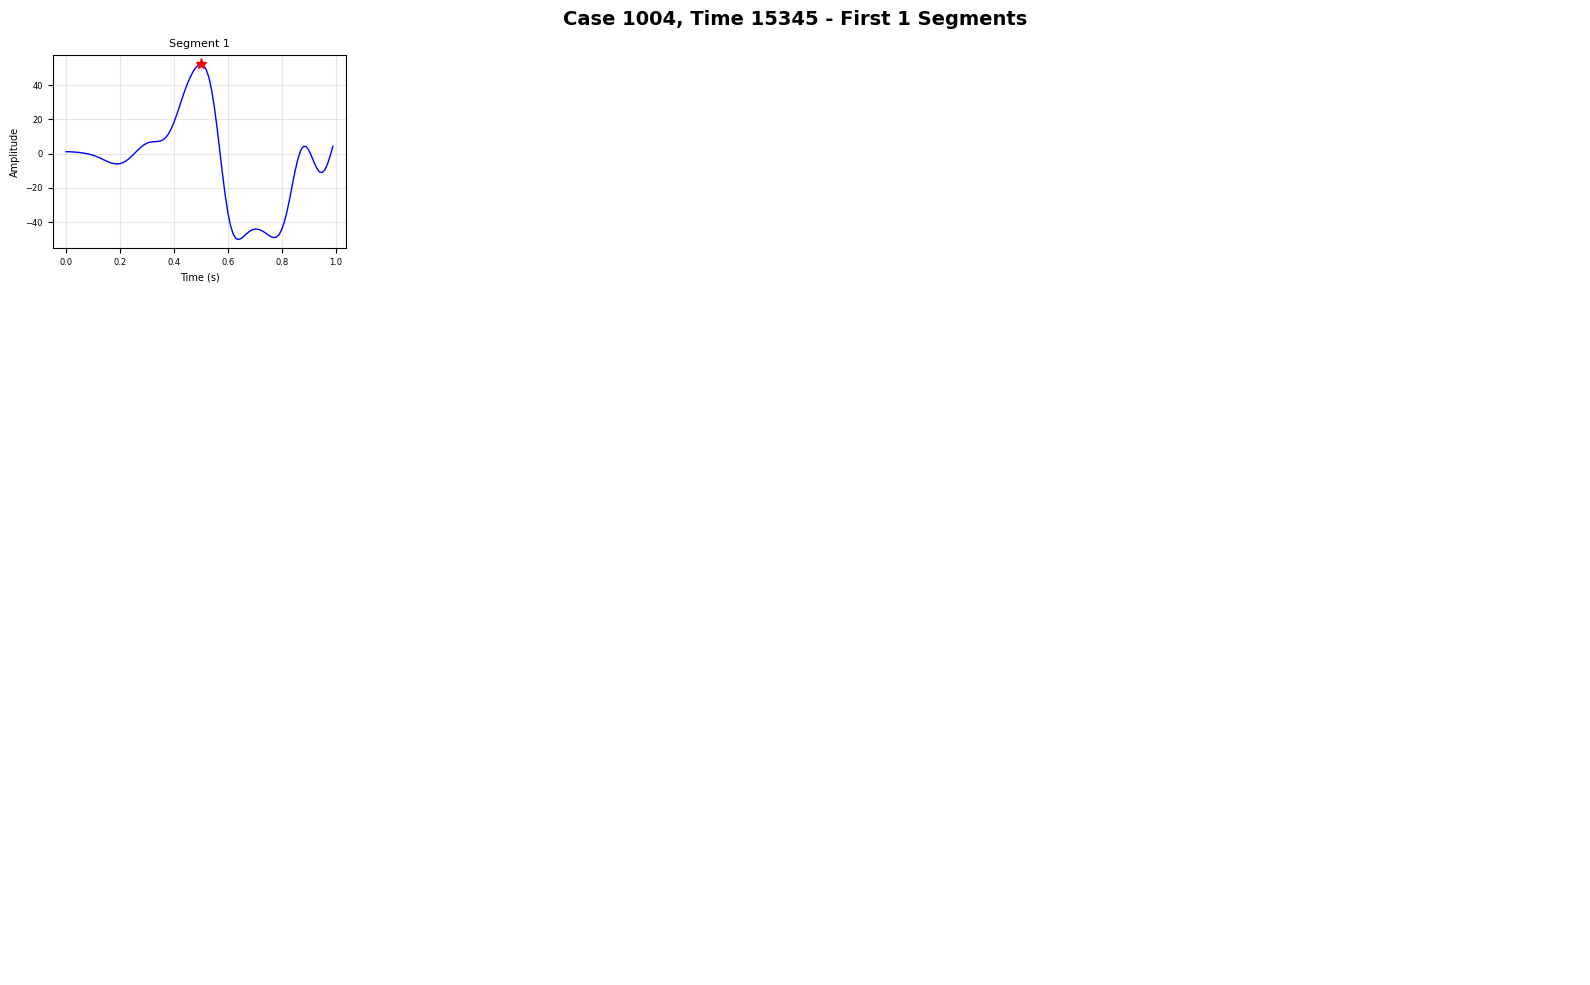

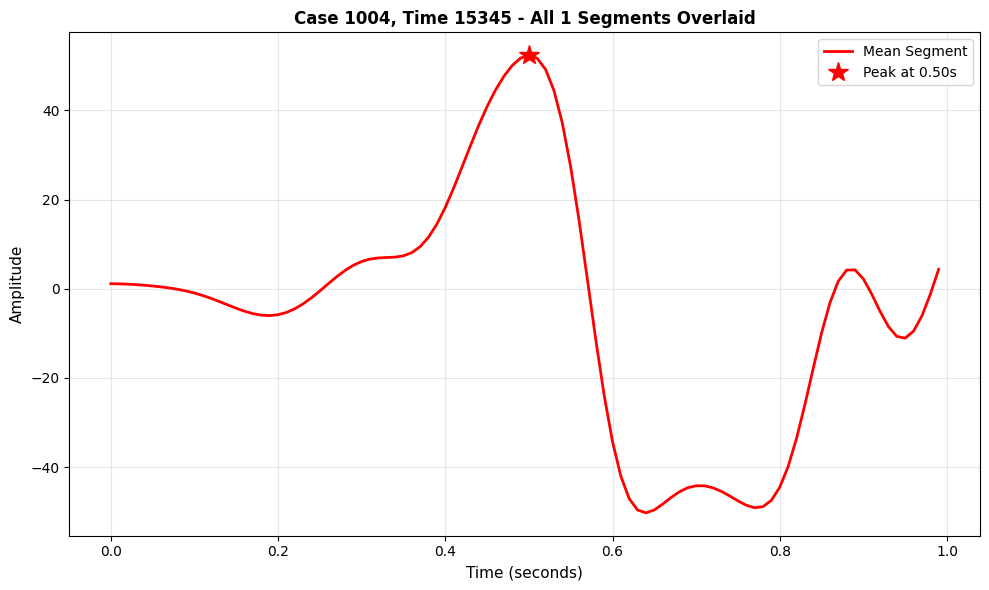

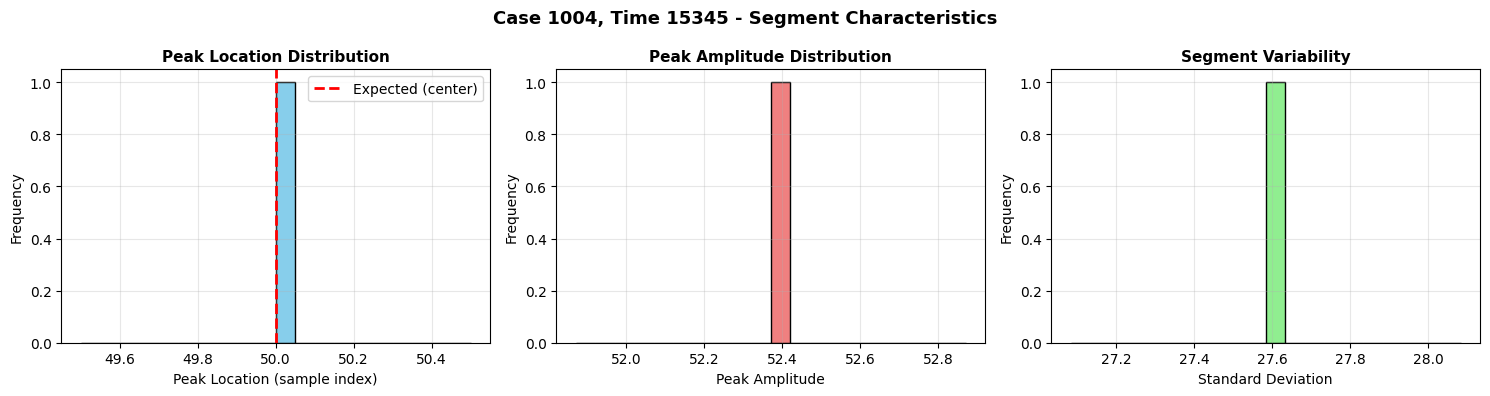


Peak Location Statistics:
  Mean peak index: 50.0 (expected: 50)
  Std of peak index: 0.0
  Peaks centered? Yes

Plots saved:
  - /content/segments_case_1004_overview.png
  - /content/segments_case_1004_overlay.png
  - /content/segments_case_1004_stats.png

FILE 2: Case 1026, Glucose Time 4891
Number of segments: 3
Segment shape: (3, 100)
Each segment: 100 samples (1 second at 100 Hz)

Segment Statistics:
  Mean amplitude: 0.44 ± 9.78
  Min amplitude: -21.44
  Max amplitude: 26.54


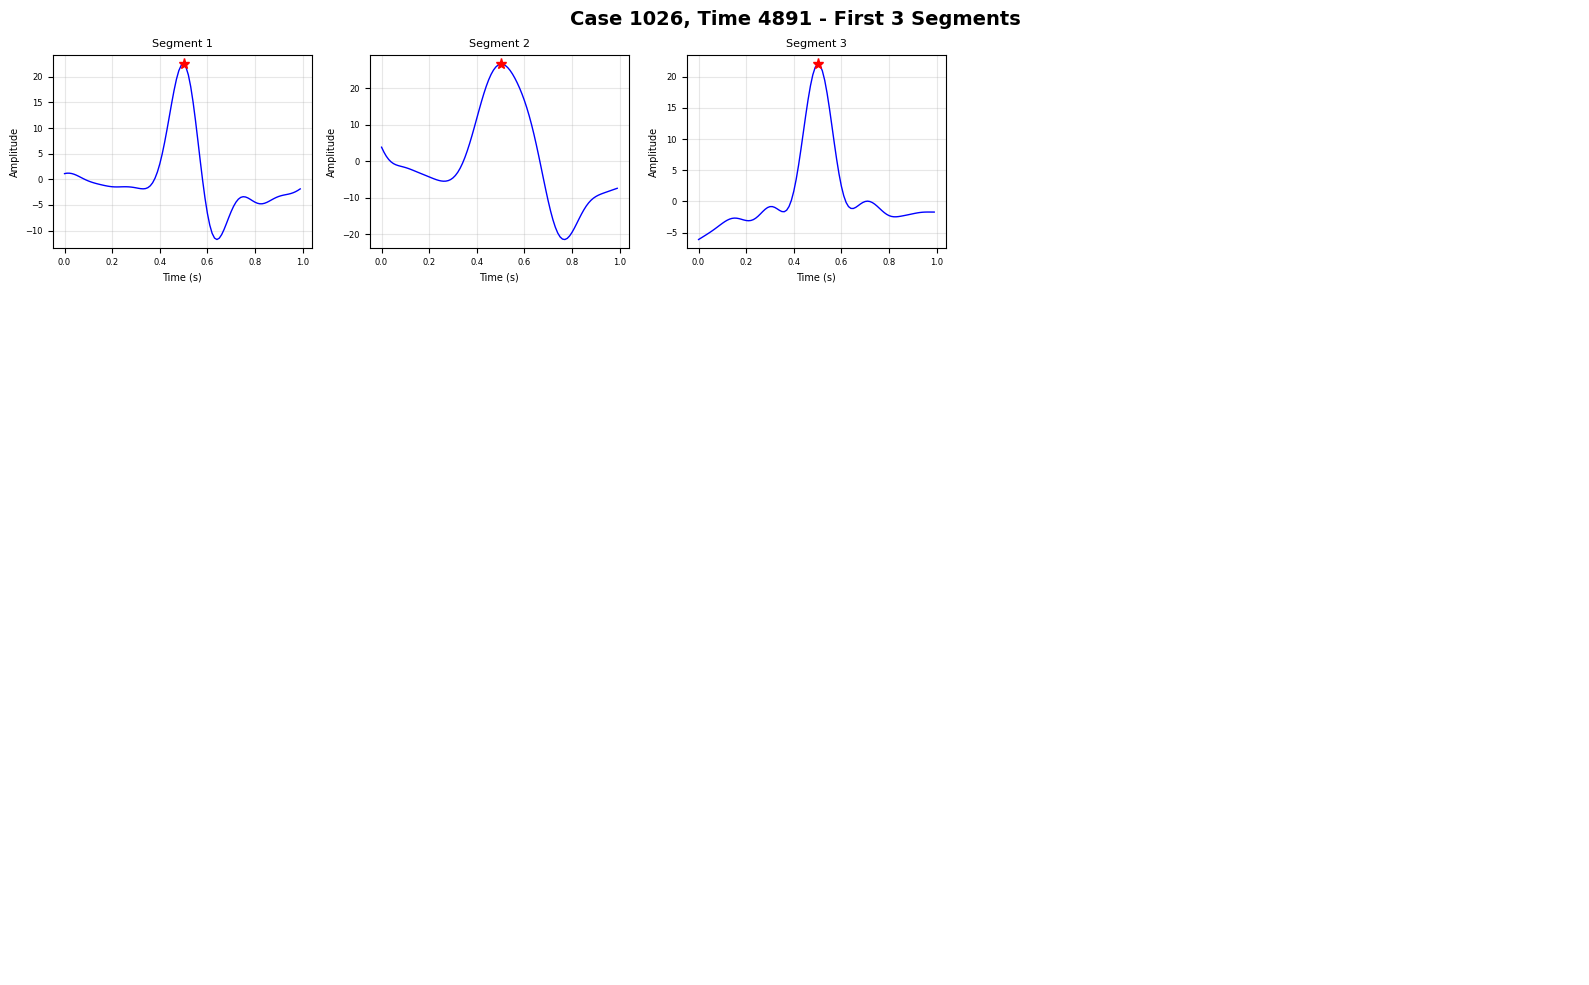

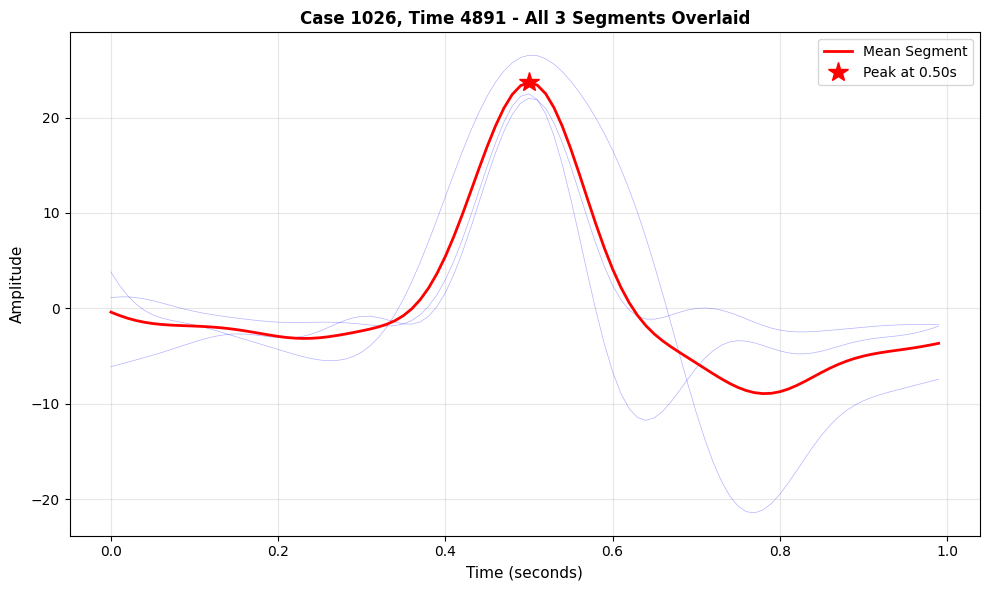

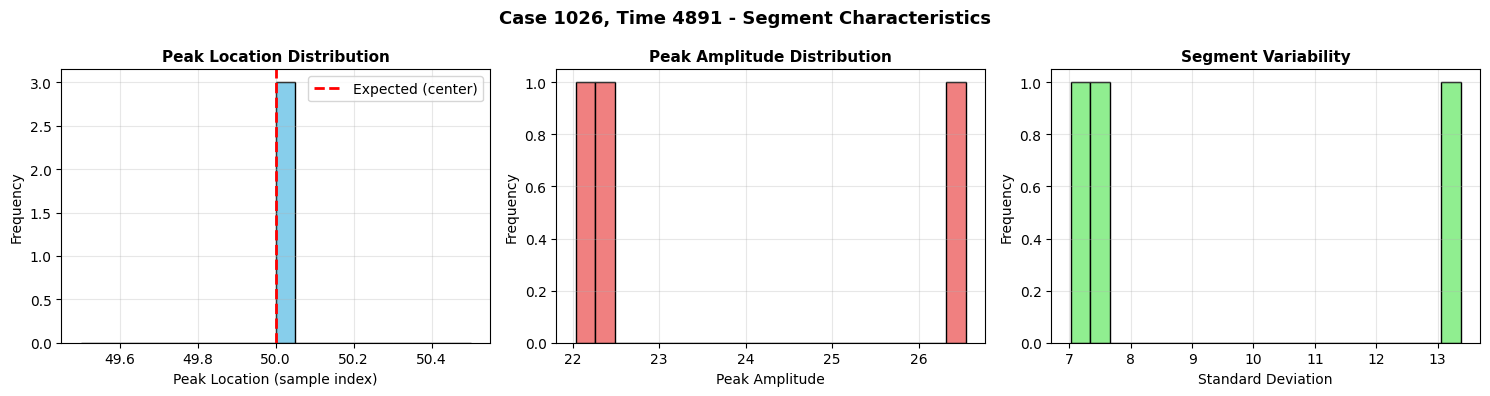


Peak Location Statistics:
  Mean peak index: 50.0 (expected: 50)
  Std of peak index: 0.0
  Peaks centered? Yes

Plots saved:
  - /content/segments_case_1026_overview.png
  - /content/segments_case_1026_overlay.png
  - /content/segments_case_1026_stats.png

FILE 3: Case 1029, Glucose Time 16590
Number of segments: 355
Segment shape: (355, 100)
Each segment: 100 samples (1 second at 100 Hz)

Segment Statistics:
  Mean amplitude: 0.35 ± 12.60
  Min amplitude: -17.24
  Max amplitude: 34.58


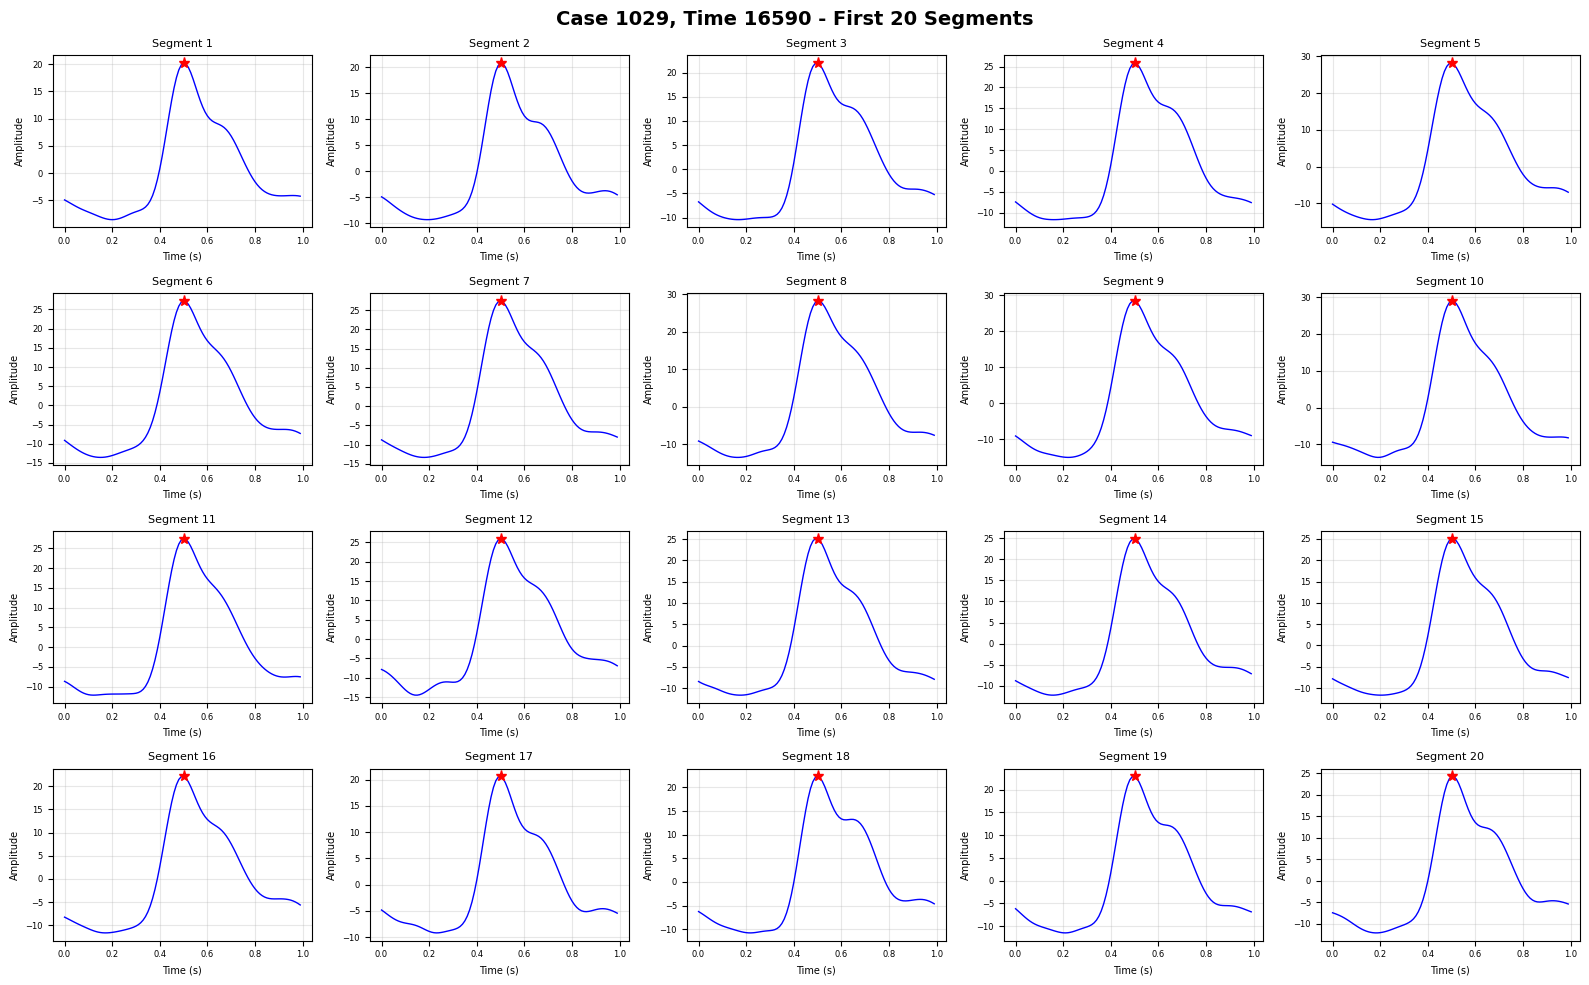

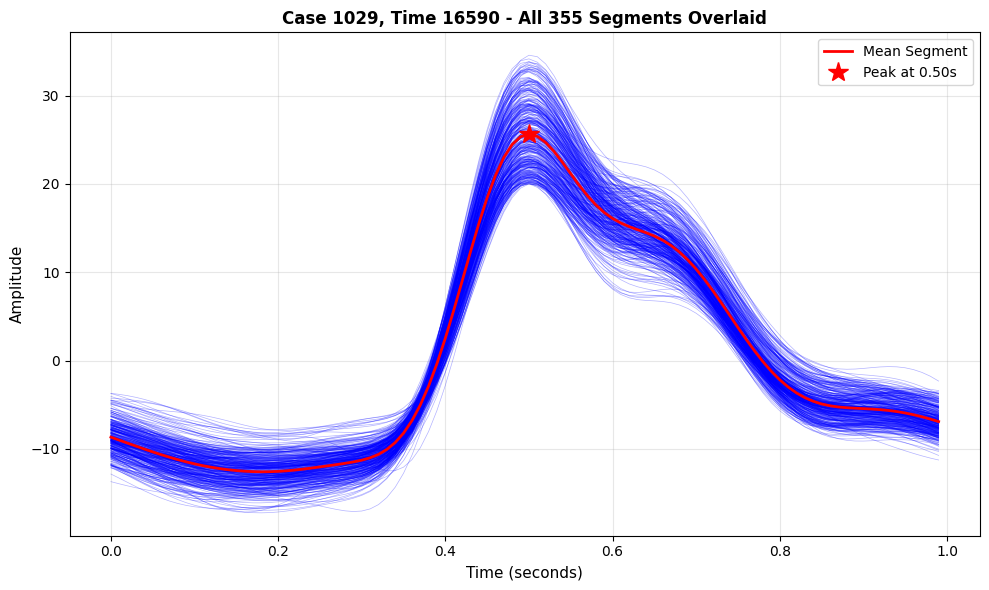

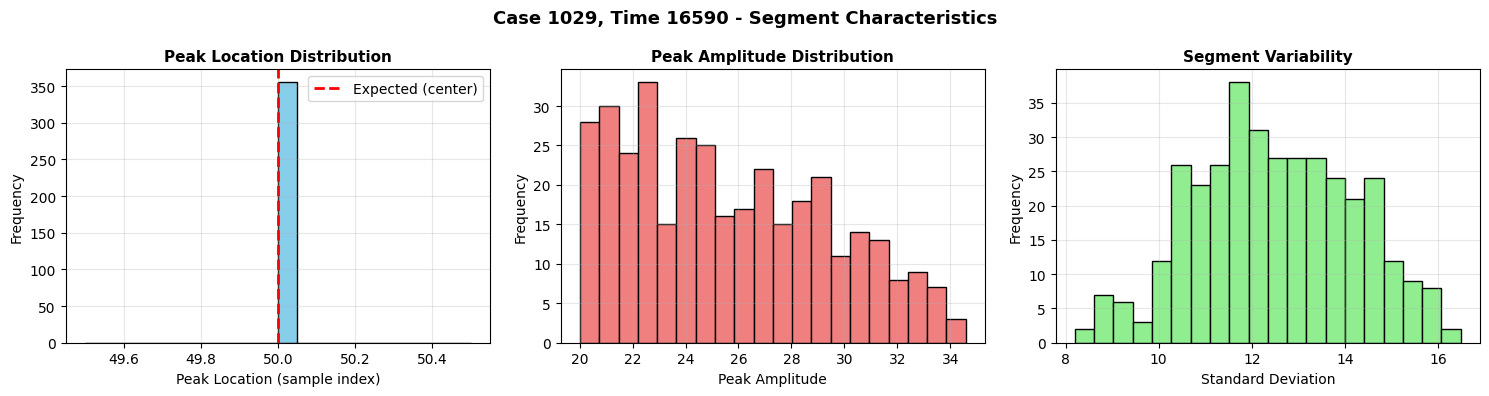


Peak Location Statistics:
  Mean peak index: 50.0 (expected: 50)
  Std of peak index: 0.0
  Peaks centered? Yes

Plots saved:
  - /content/segments_case_1029_overview.png
  - /content/segments_case_1029_overlay.png
  - /content/segments_case_1029_stats.png

FILE 4: Case 1025, Glucose Time 12627
Number of segments: 777
Segment shape: (777, 100)
Each segment: 100 samples (1 second at 100 Hz)

Segment Statistics:
  Mean amplitude: 0.74 ± 11.70
  Min amplitude: -23.69
  Max amplitude: 36.88


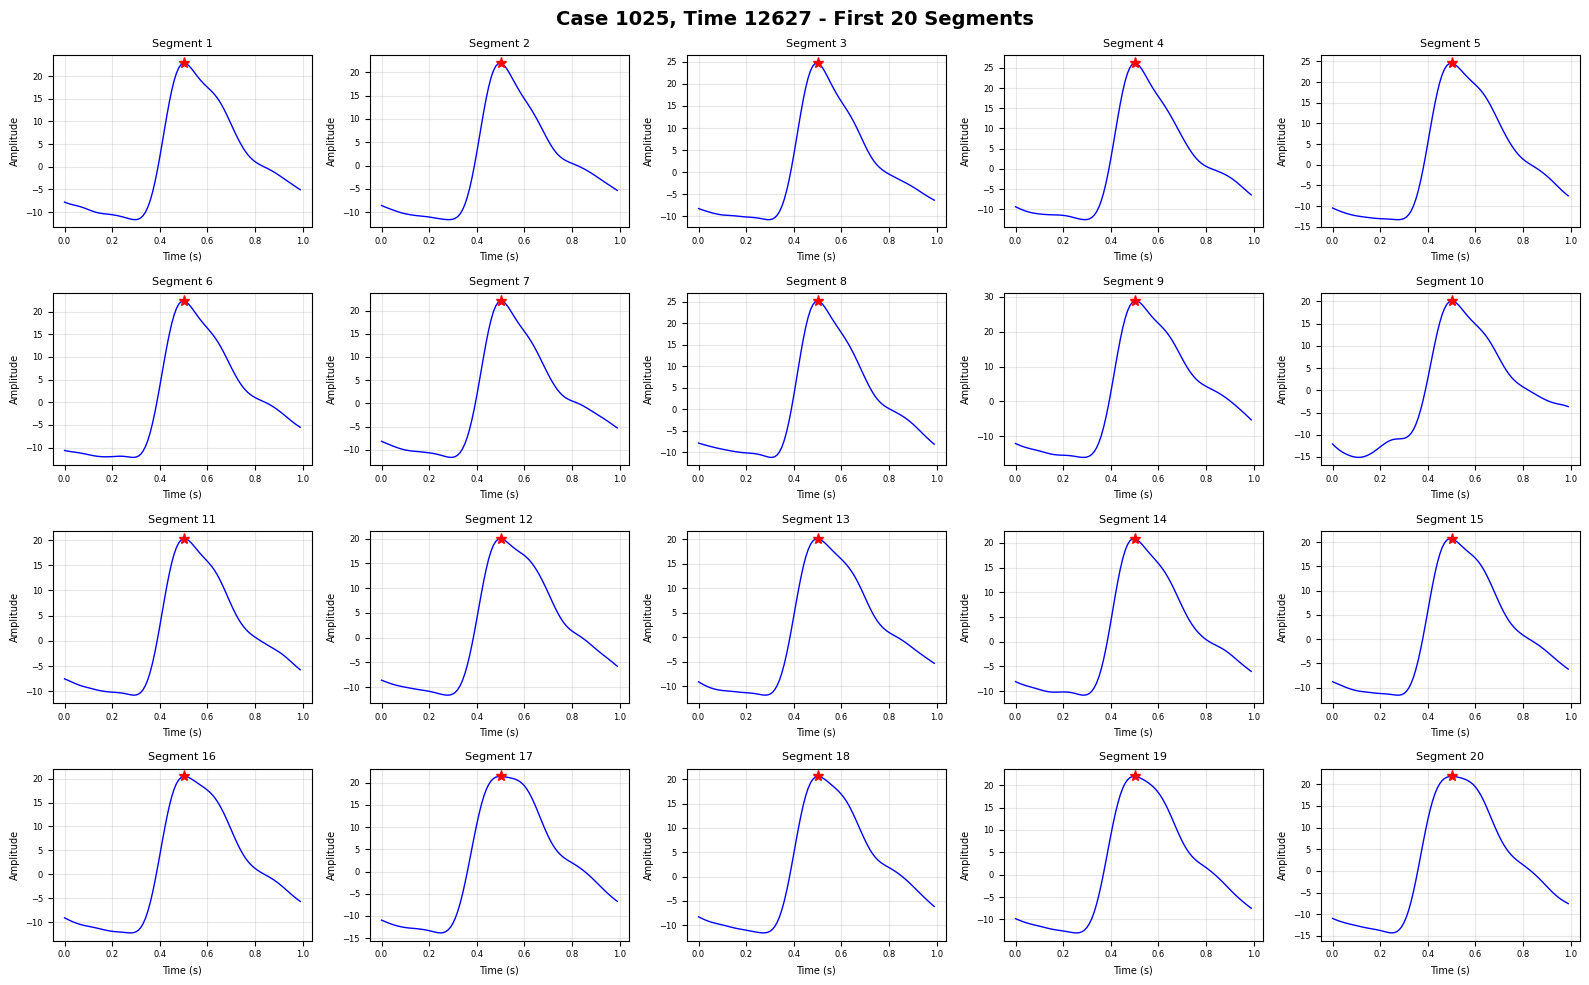

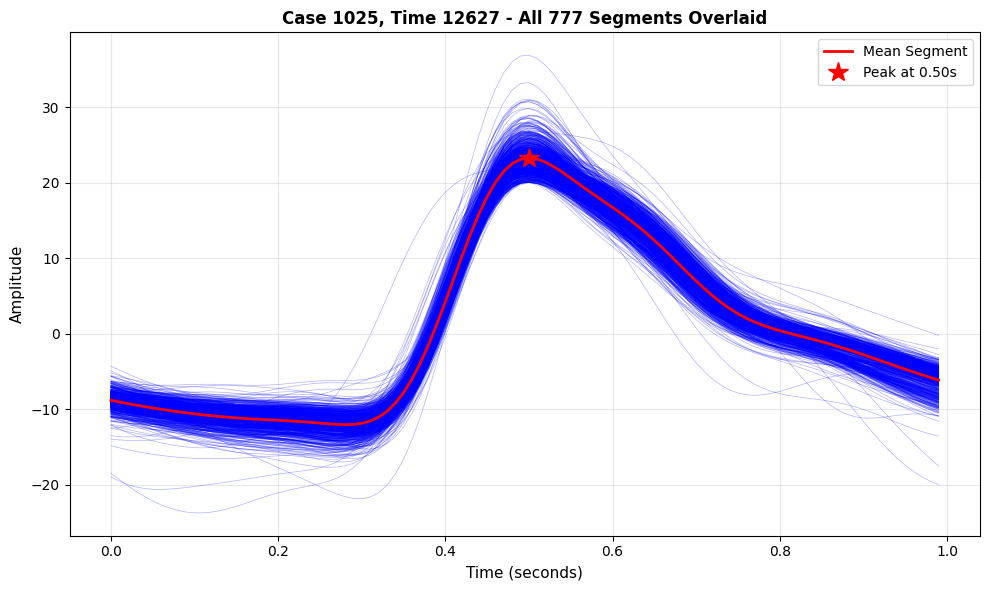

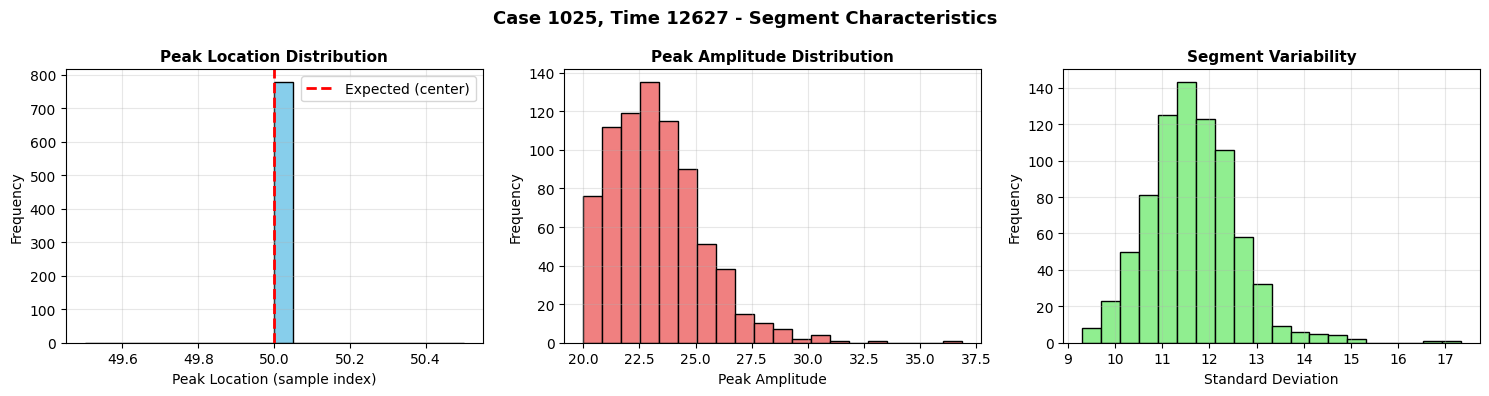


Peak Location Statistics:
  Mean peak index: 50.0 (expected: 50)
  Std of peak index: 0.0
  Peaks centered? Yes

Plots saved:
  - /content/segments_case_1025_overview.png
  - /content/segments_case_1025_overlay.png
  - /content/segments_case_1025_stats.png

FILE 5: Case 1022, Glucose Time 1109
Number of segments: 1030
Segment shape: (1030, 100)
Each segment: 100 samples (1 second at 100 Hz)

Segment Statistics:
  Mean amplitude: -1.34 ± 11.52
  Min amplitude: -31.63
  Max amplitude: 30.38


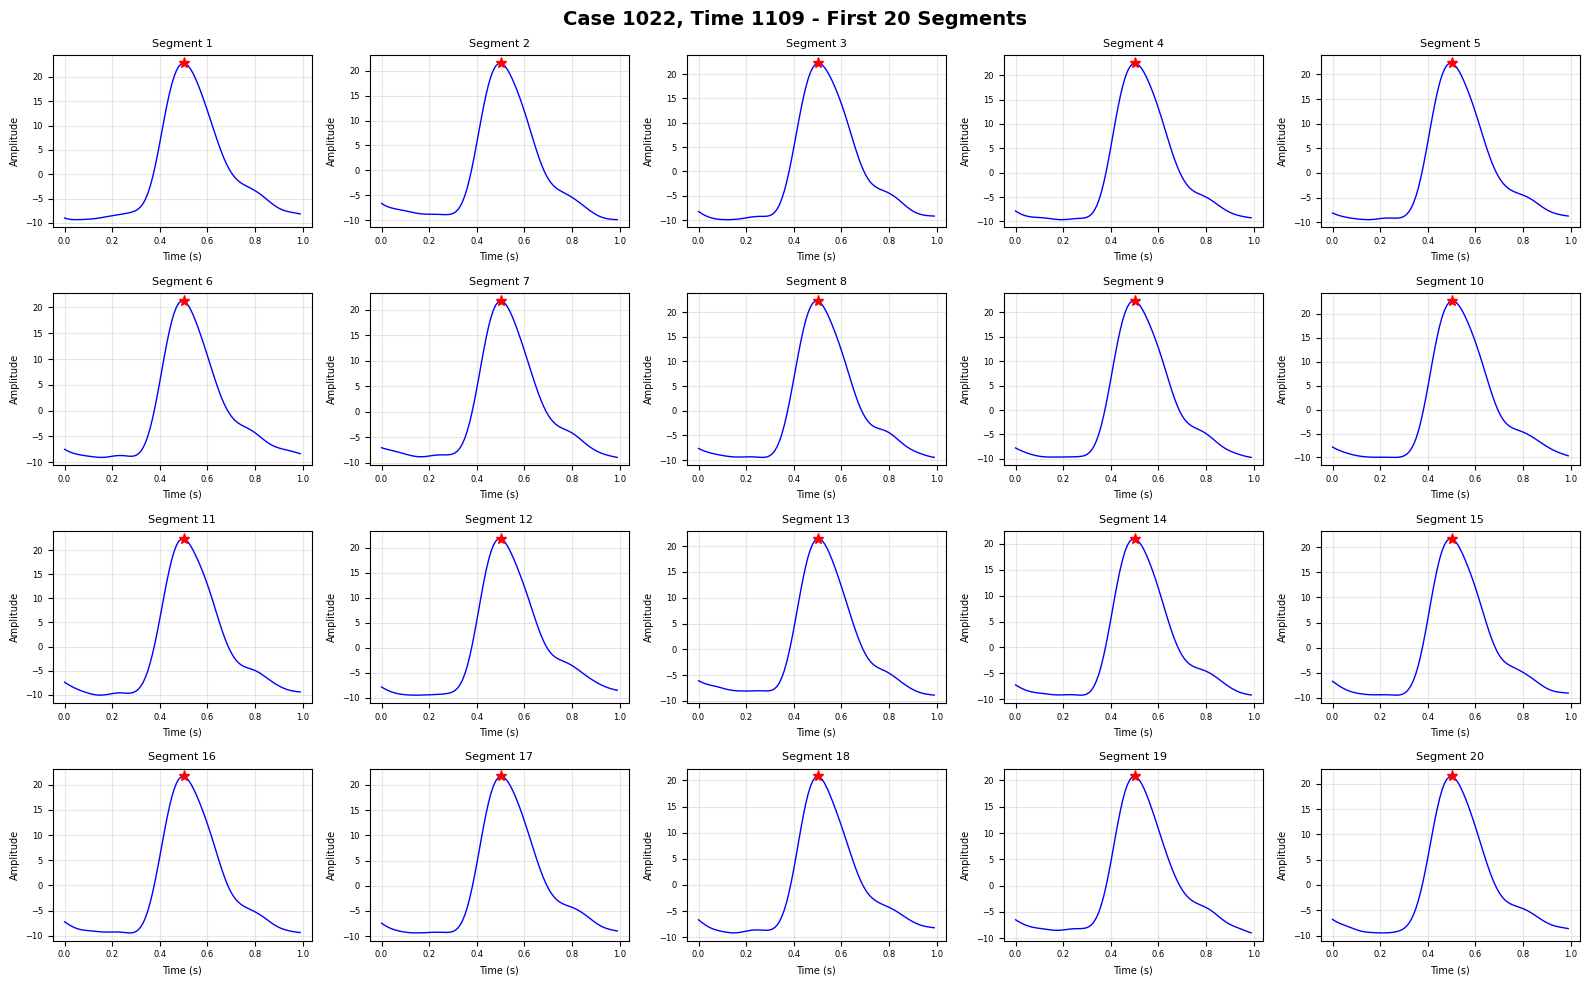

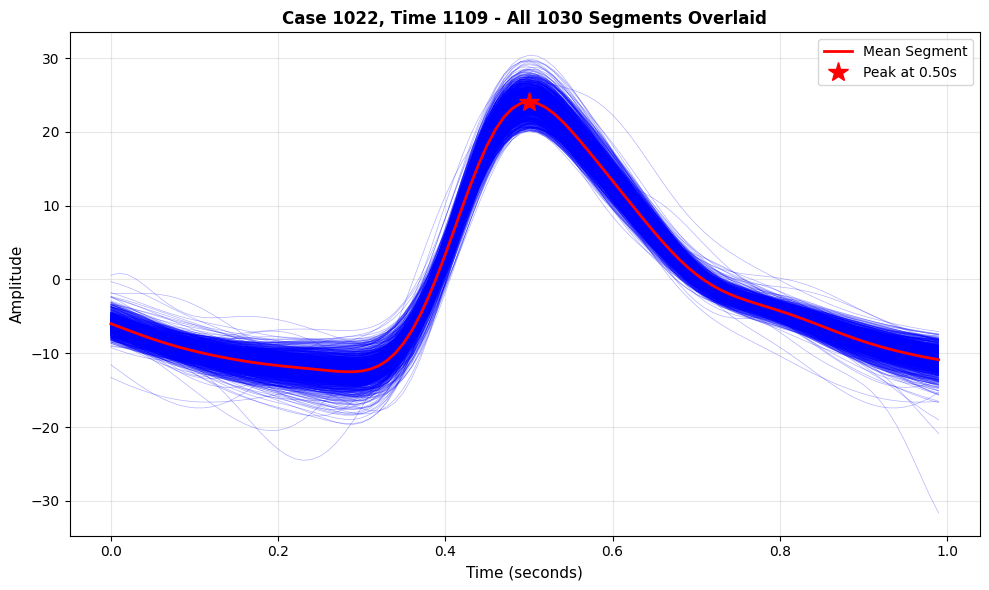

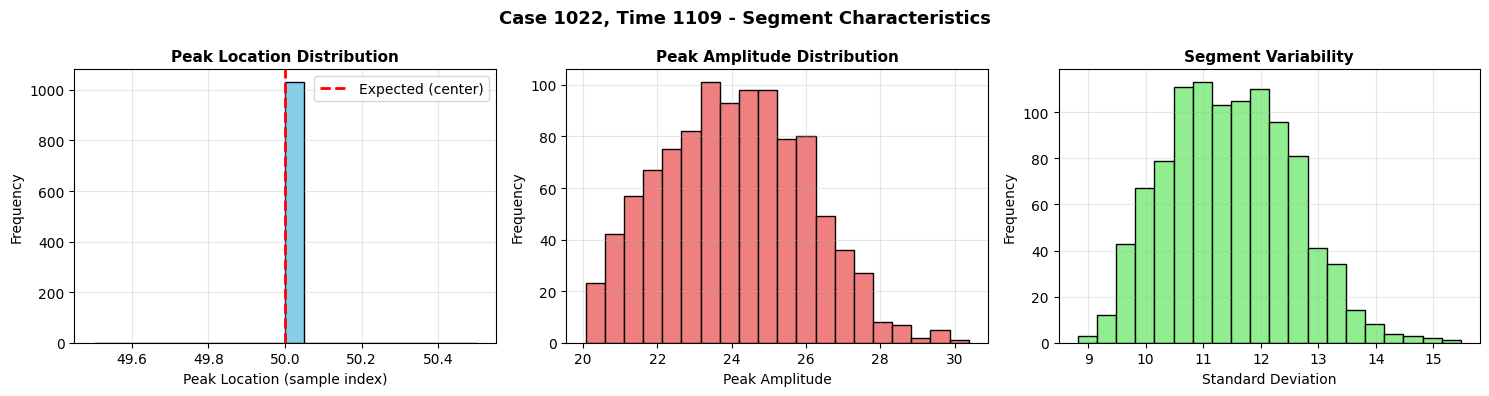


Peak Location Statistics:
  Mean peak index: 50.0 (expected: 50)
  Std of peak index: 0.0
  Peaks centered? Yes

Plots saved:
  - /content/segments_case_1022_overview.png
  - /content/segments_case_1022_overlay.png
  - /content/segments_case_1022_stats.png

VISUALIZATION COMPLETE


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Parameters
SEGMENT_PATH = '/content/drive/MyDrive/2025_PPG_GLUC/Data/Final Data/1s_segmentation2/'
FS = 100  # Sampling rate (Hz)

#Loading segment files
segment_files = sorted(Path(SEGMENT_PATH).glob('case_*_1s_segments.npy'))
print(f"Total segment files available: {len(segment_files)}\n")

# Select 5 sample files with different characteristics
# Find files with different numbers of segments
file_info = []
for f in segment_files[:50]:  # Check first 50 files
    try:
        data = np.load(f)
        n_segments = data.shape[0] if len(data.shape) > 1 else 1
        file_info.append((f, n_segments))
    except:
        continue

# Sort by number of segments
file_info.sort(key=lambda x: x[1])

# Select: smallest, small, medium, large, largest
indices = [0, len(file_info)//4, len(file_info)//2, 3*len(file_info)//4, -1]
sample_files = [file_info[i][0] for i in indices]

print("\nSelected files:")
for i, (f, n_seg) in enumerate([file_info[idx] for idx in indices], 1):
    print(f"  {i}. {f.name} - {n_seg} segments")
print()


for file_idx, seg_file in enumerate(sample_files, 1):
    # Parse filename
    parts = seg_file.stem.split('_')
    caseid = parts[1]
    glucose_time = parts[3]

    # Load segments
    segments = np.load(seg_file)

    # Handle both 1D (single segment) and 2D (multiple segments)
    if len(segments.shape) == 1:
        segments = segments.reshape(1, -1)

    n_segments = segments.shape[0]

    print(f"\n{'='*70}")
    print(f"FILE {file_idx}: Case {caseid}, Glucose Time {glucose_time}")
    print(f"{'='*70}")
    print(f"Number of segments: {n_segments}")
    print(f"Segment shape: {segments.shape}")
    print(f"Each segment: {segments.shape[1]} samples (1 second at {FS} Hz)")

    # Calculate statistics
    print(f"\nSegment Statistics:")
    print(f"  Mean amplitude: {segments.mean():.2f} ± {segments.std():.2f}")
    print(f"  Min amplitude: {segments.min():.2f}")
    print(f"  Max amplitude: {segments.max():.2f}")

    # Plot 1: Showing first 20 segments
    n_to_show = min(20, n_segments)

    fig1, axes1 = plt.subplots(4, 5, figsize=(16, 10))
    axes1 = axes1.flatten()

    for i in range(n_to_show):
        ax = axes1[i]
        time = np.arange(segments.shape[1]) / FS

        ax.plot(time, segments[i], 'b-', linewidth=1)
        ax.set_title(f'Segment {i+1}', fontsize=8)
        ax.set_xlabel('Time (s)', fontsize=7)
        ax.set_ylabel('Amplitude', fontsize=7)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=6)

        # Mark peak (should be around center)
        peak_idx = np.argmax(segments[i])
        ax.plot(time[peak_idx], segments[i][peak_idx], 'r*', markersize=8)

    # Hide unused subplots
    for i in range(n_to_show, 20):
        axes1[i].axis('off')

    plt.suptitle(f'Case {caseid}, Time {glucose_time} - First {n_to_show} Segments',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'/content/segments_case_{caseid}_overview.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Plot 2: Show all segments overlaid
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    time = np.arange(segments.shape[1]) / FS

    # Plot all segments with transparency
    for i in range(n_segments):
        ax2.plot(time, segments[i], 'b-', linewidth=0.5, alpha=0.3)

    # Plot mean segment (template)
    mean_segment = segments.mean(axis=0)
    ax2.plot(time, mean_segment, 'r-', linewidth=2, label='Mean Segment', zorder=100)

    # Mark peak on mean
    peak_idx = np.argmax(mean_segment)
    ax2.plot(time[peak_idx], mean_segment[peak_idx], 'r*', markersize=15,
             label=f'Peak at {time[peak_idx]:.2f}s')

    ax2.set_xlabel('Time (seconds)', fontsize=11)
    ax2.set_ylabel('Amplitude', fontsize=11)
    ax2.set_title(f'Case {caseid}, Time {glucose_time} - All {n_segments} Segments Overlaid',
                  fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'/content/segments_case_{caseid}_overlay.png', dpi=150, bbox_inches='tight')
    plt.show()


    # Plot 3 Distributions
    fig3, axes3 = plt.subplots(1, 3, figsize=(15, 4))

    # Find peak location in each segment
    peak_locations = [np.argmax(seg) for seg in segments]
    peak_amplitudes = [seg[np.argmax(seg)] for seg in segments]

    # Plot 1: Peak location histogram
    axes3[0].hist(peak_locations, bins=20, color='skyblue', edgecolor='black')
    axes3[0].axvline(x=50, color='red', linestyle='--', linewidth=2, label='Expected (center)')
    axes3[0].set_xlabel('Peak Location (sample index)', fontsize=10)
    axes3[0].set_ylabel('Frequency', fontsize=10)
    axes3[0].set_title('Peak Location Distribution', fontsize=11, fontweight='bold')
    axes3[0].legend()
    axes3[0].grid(True, alpha=0.3)

    # Plot 2: Peak amplitude histogram
    axes3[1].hist(peak_amplitudes, bins=20, color='lightcoral', edgecolor='black')
    axes3[1].set_xlabel('Peak Amplitude', fontsize=10)
    axes3[1].set_ylabel('Frequency', fontsize=10)
    axes3[1].set_title('Peak Amplitude Distribution', fontsize=11, fontweight='bold')
    axes3[1].grid(True, alpha=0.3)

    # Plot 3: Segment-to-segment variation
    segment_stds = segments.std(axis=1)
    axes3[2].hist(segment_stds, bins=20, color='lightgreen', edgecolor='black')
    axes3[2].set_xlabel('Standard Deviation', fontsize=10)
    axes3[2].set_ylabel('Frequency', fontsize=10)
    axes3[2].set_title('Segment Variability', fontsize=11, fontweight='bold')
    axes3[2].grid(True, alpha=0.3)

    plt.suptitle(f'Case {caseid}, Time {glucose_time} - Segment Characteristics',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'/content/segments_case_{caseid}_stats.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nPeak Location Statistics:")
    print(f"  Mean peak index: {np.mean(peak_locations):.1f} (expected: 50)")
    print(f"  Std of peak index: {np.std(peak_locations):.1f}")
    print(f"  Peaks centered? {'Yes' if 45 <= np.mean(peak_locations) <= 55 else 'No'}")

    print(f"\nPlots saved:")
    print(f"  - /content/segments_case_{caseid}_overview.png")
    print(f"  - /content/segments_case_{caseid}_overlay.png")
    print(f"  - /content/segments_case_{caseid}_stats.png")

print(f"\n{'='*70}")
print("VISUALIZATION COMPLETE")
print(f"{'='*70}")